In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
import itertools
from pylab import rcParams
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('PJMW_MW_Hourly.xlsx',header=0,parse_dates=True)
data

Datetime  PJMW_MW
0      2002-12-31 01:00:00     5077
1      2002-12-31 02:00:00     4939
2      2002-12-31 03:00:00     4885
3      2002-12-31 04:00:00     4857
4      2002-12-31 05:00:00     4930
...                    ...      ...
143201 2018-01-01 20:00:00     8401
143202 2018-01-01 21:00:00     8373
143203 2018-01-01 22:00:00     8238
143204 2018-01-01 23:00:00     7958
143205 2018-01-02 00:00:00     7691

[143206 rows x 2 columns]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  143206 non-null  datetime64[ns]
 1   PJMW_MW   143206 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.2 MB


In [4]:
data.describe()

PJMW_MW
count  143206.000000
mean     5602.375089
std       979.142872
min       487.000000
25%      4907.000000
50%      5530.000000
75%      6252.000000
max      9594.000000

In [5]:
data.shape

(143206, 2)

In [6]:
data.dtypes

Datetime    datetime64[ns]
PJMW_MW              int64
dtype: object

In [7]:
data.nunique()

Datetime    143202
PJMW_MW       5343
dtype: int64

In [8]:
data.set_index('Datetime', inplace=True)

In [9]:
data.head()

PJMW_MW
Datetime                    
2002-12-31 01:00:00     5077
2002-12-31 02:00:00     4939
2002-12-31 03:00:00     4885
2002-12-31 04:00:00     4857
2002-12-31 05:00:00     4930

In [10]:
df= data.copy()

In [11]:
df.head()

PJMW_MW
Datetime                    
2002-12-31 01:00:00     5077
2002-12-31 02:00:00     4939
2002-12-31 03:00:00     4885
2002-12-31 04:00:00     4857
2002-12-31 05:00:00     4930

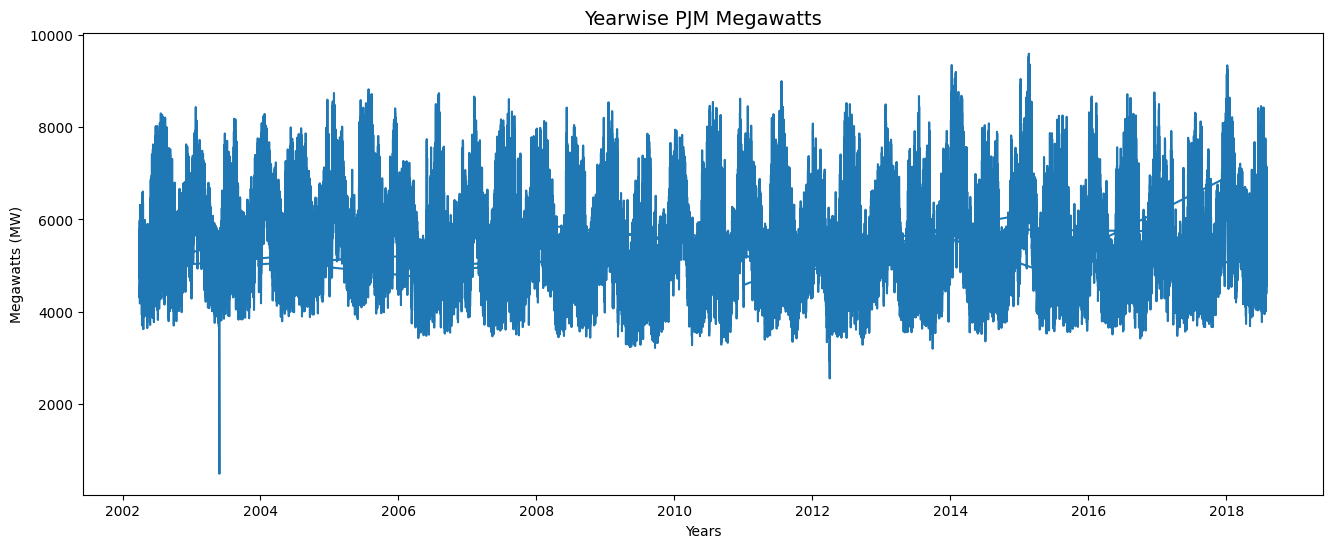

In [12]:
#line chart
plt.figure(figsize = (16, 6))
plt.rcParams['figure.dpi']= 300
plt.plot(df['PJMW_MW']) 
plt.title('Yearwise PJM Megawatts',fontdict={'fontsize': 14,'color': 'black'})
plt.xlabel('Years')
plt.ylabel('Megawatts (MW)')
plt.show()

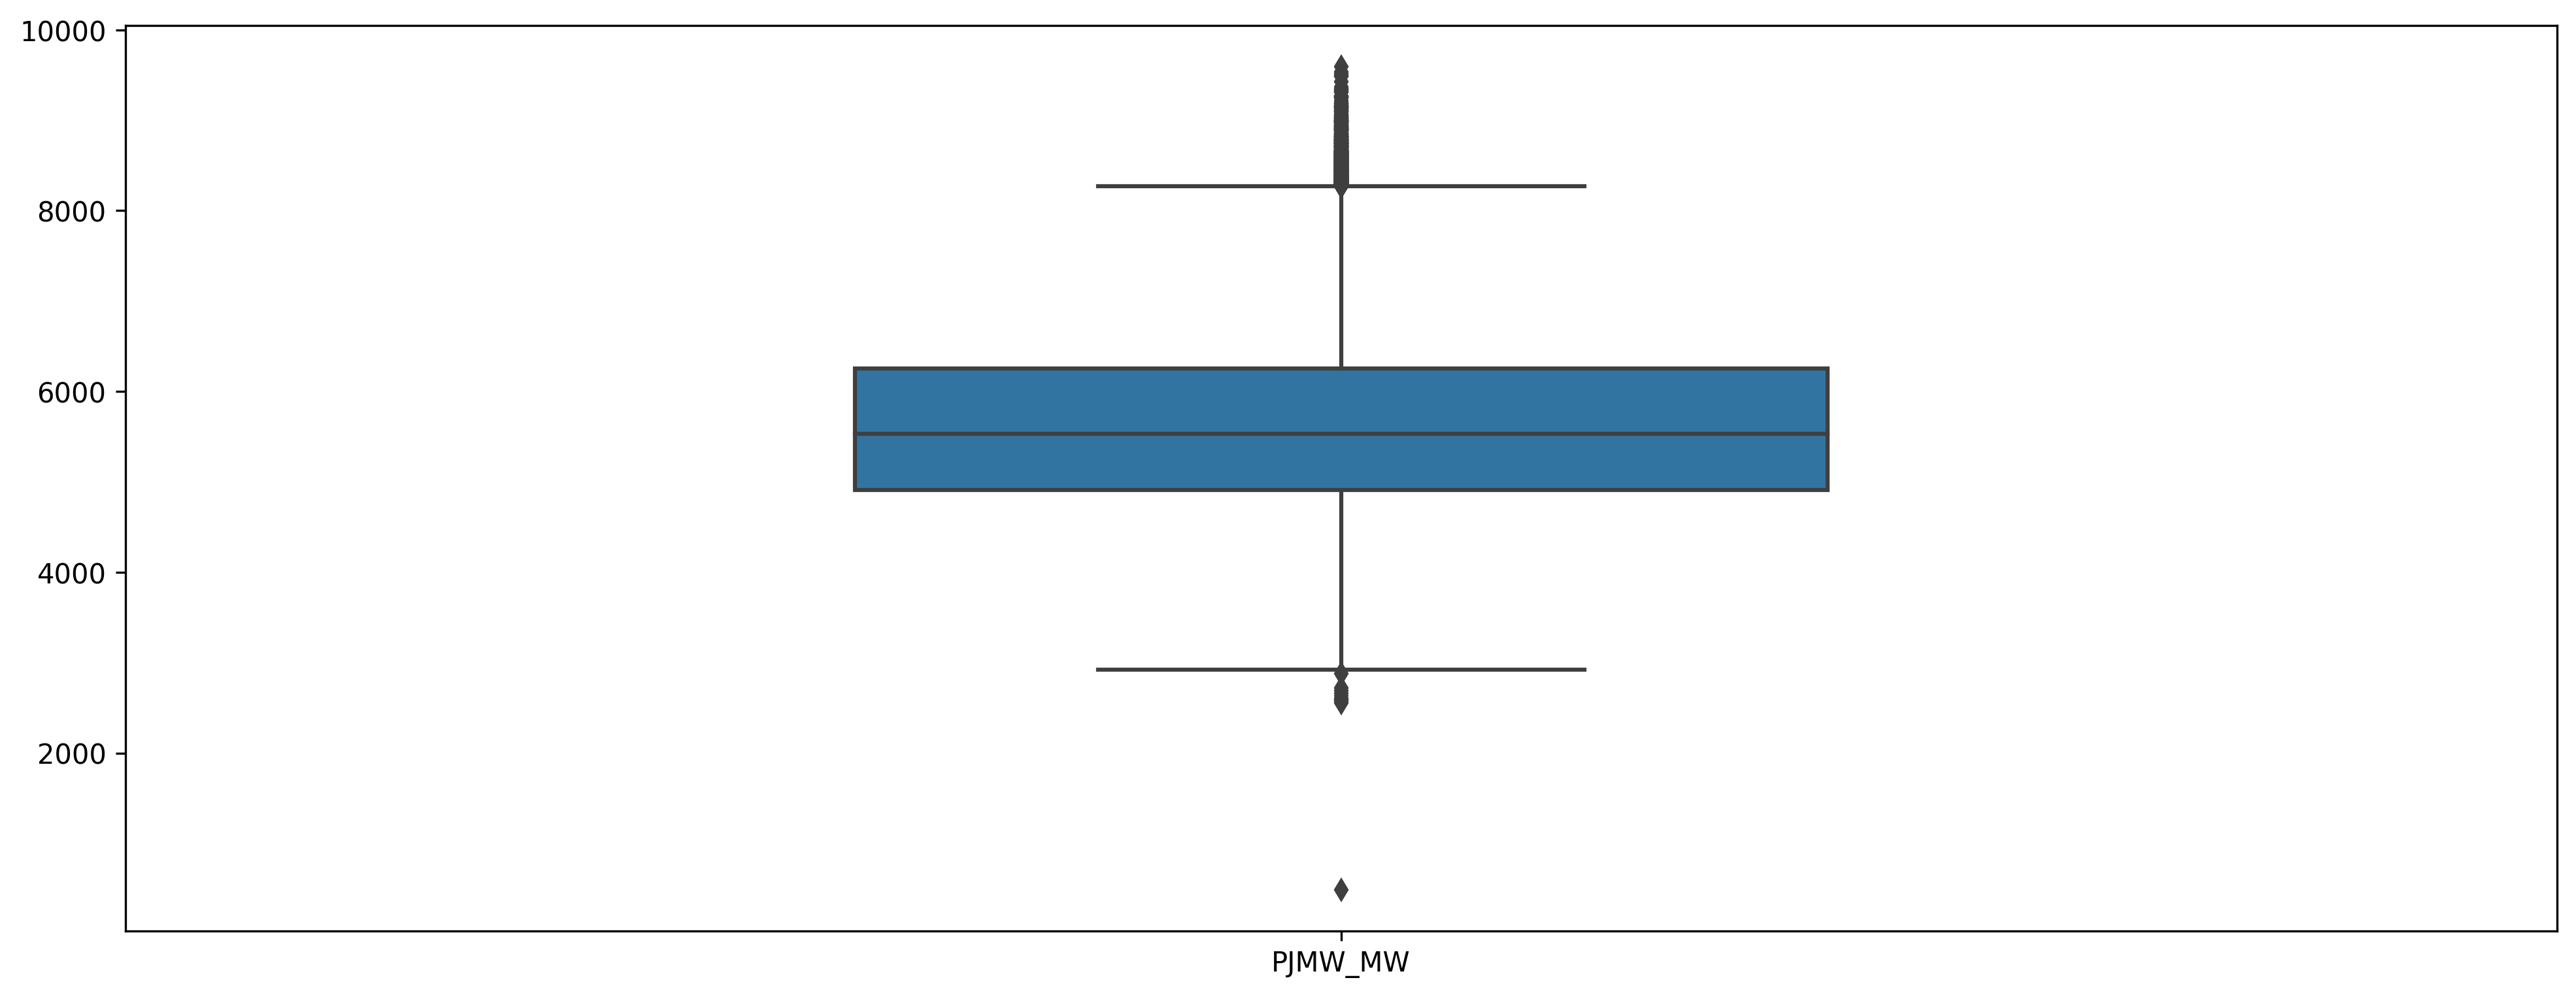

In [13]:
#checking for outleries

plt.figure(figsize=(16,6))
sns.boxplot(data =df,width=0.4)
plt.show()

<Figure size 4800x1800 with 0 Axes>

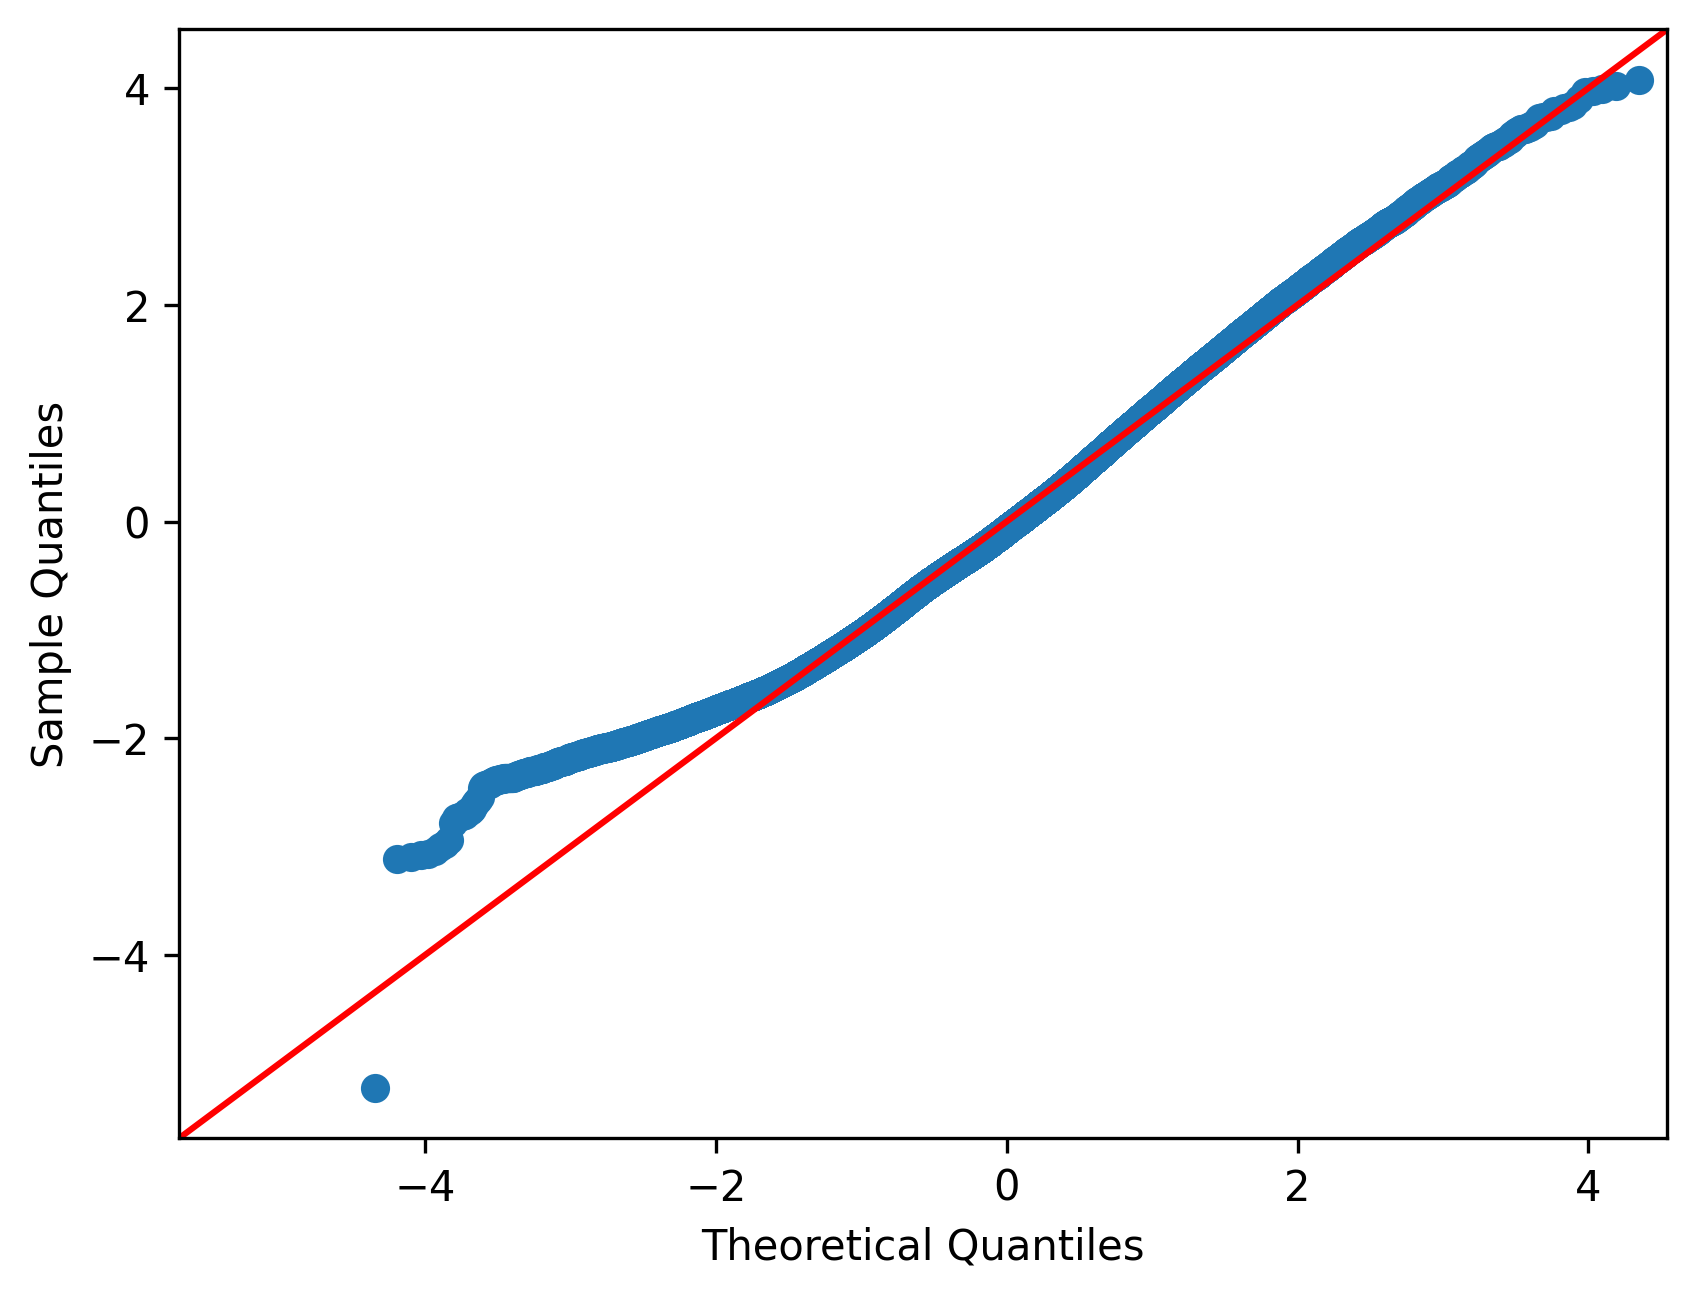

In [14]:
plt.figure(figsize=(16,6))
plot = sm.qqplot(df['PJMW_MW'],line = "45", fit=True)

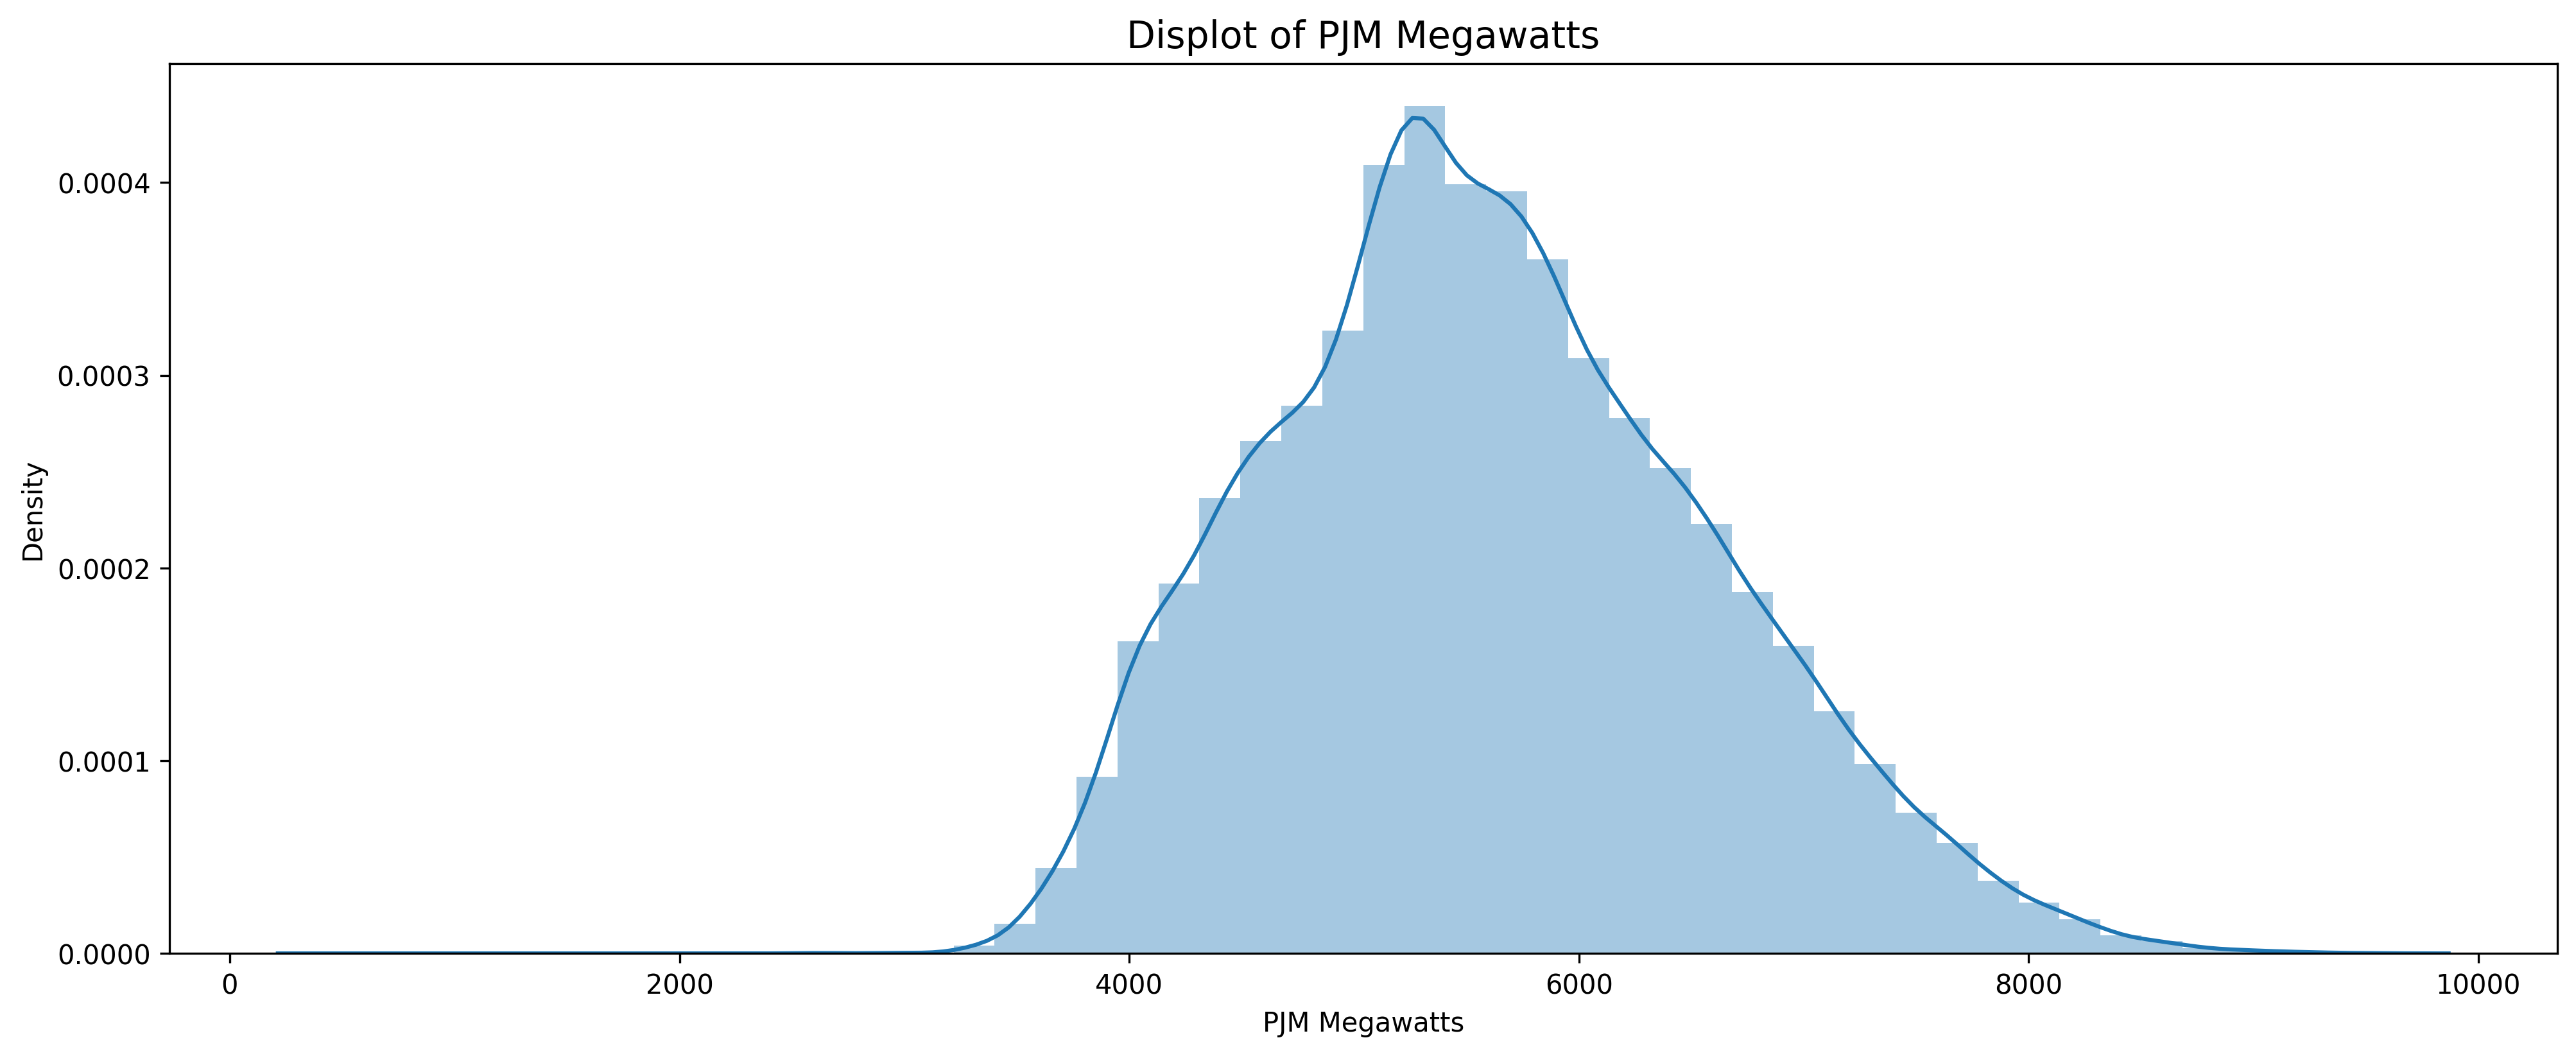

In [15]:
# line plot

plt.figure(figsize=(16,6))
sns.distplot(df['PJMW_MW'])
plt.title('Displot of PJM Megawatts',fontdict={'fontsize': 14,'color': 'black'})
plt.xlabel('PJM Megawatts')
plt.show()

In [16]:
#Finding outliers

def find_outliers_IQR(df):
    
    Q1 = df.quantile(0.25)

    Q3 = df.quantile(0.75)
    
    IQR = Q3 - Q1
    
    outliers= df[((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    
    return outliers

In [17]:
outliers = find_outliers_IQR(df['PJMW_MW'])

print("number of outliers:"+ str(len(outliers)))

print("max outlier value: "+str(outliers.max()))

print("min outlier value: "+str(outliers.min()))

outliers

number of outliers:703
max outlier value: 9594
min outlier value: 487


Datetime
2002-07-29 18:00:00    8270
2002-07-22 17:00:00    8300
2003-05-29 00:00:00     487
2003-01-23 18:00:00    8296
2003-01-23 19:00:00    8431
                       ... 
2018-01-02 21:00:00    8563
2018-01-02 22:00:00    8322
2018-01-01 19:00:00    8328
2018-01-01 20:00:00    8401
2018-01-01 21:00:00    8373
Name: PJMW_MW, Length: 703, dtype: int64

In [18]:
#Define the percentile limits for winsorization 

pct_lower = 0.01
pct_upper = 0.95

df['PJMW_MW'] = np.clip(df['PJMW_MW'],
                df['PJMW_MW'].quantile(pct_lower),
                df['PJMW_MW'].quantile(pct_upper))

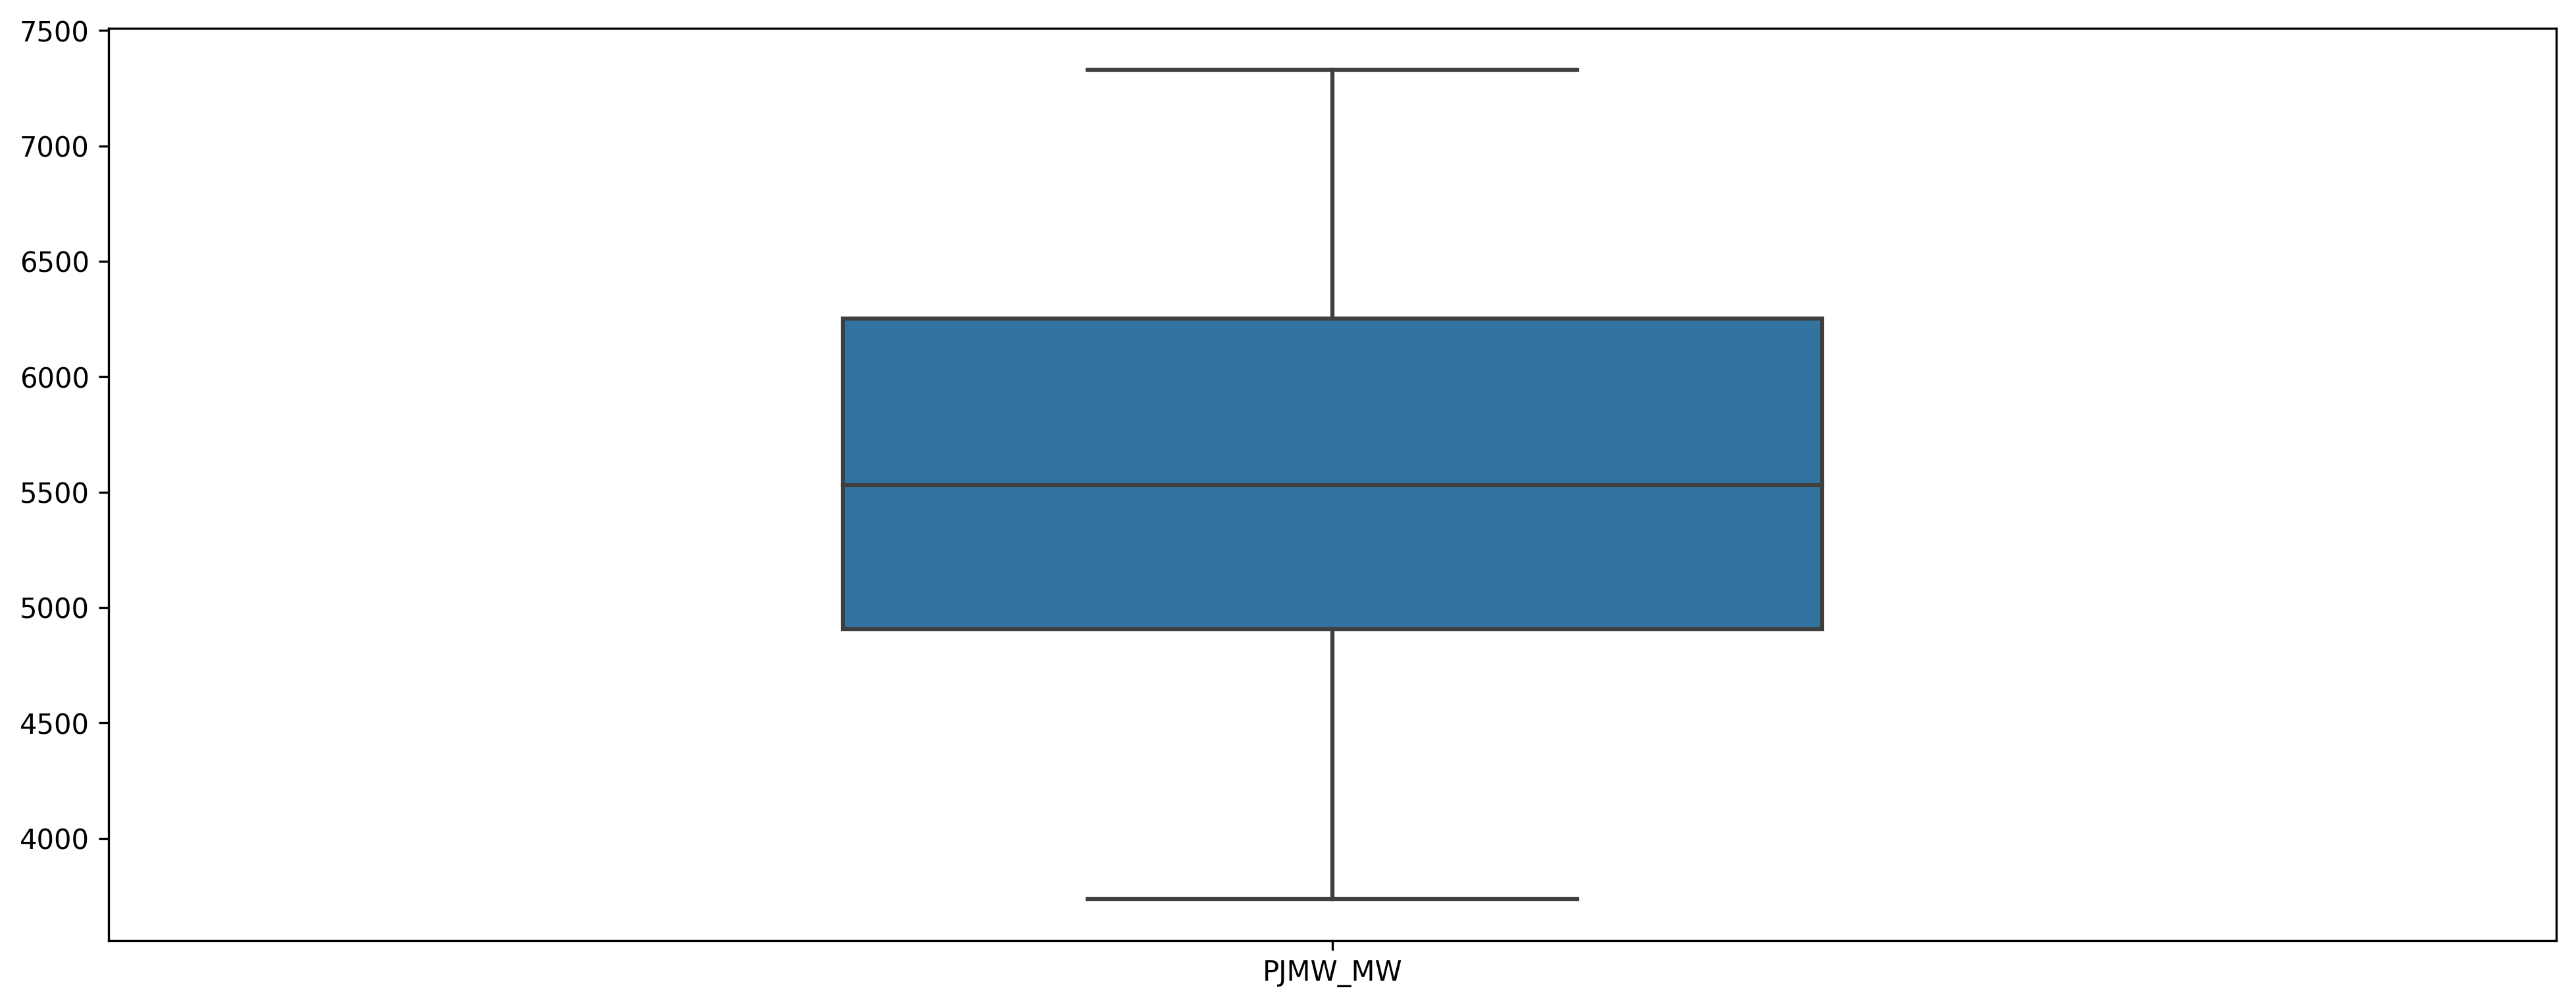

In [19]:
#rechecking for outleries

plt.figure(figsize=(16,6))
sns.boxplot(data =df,width=0.4)
plt.show()

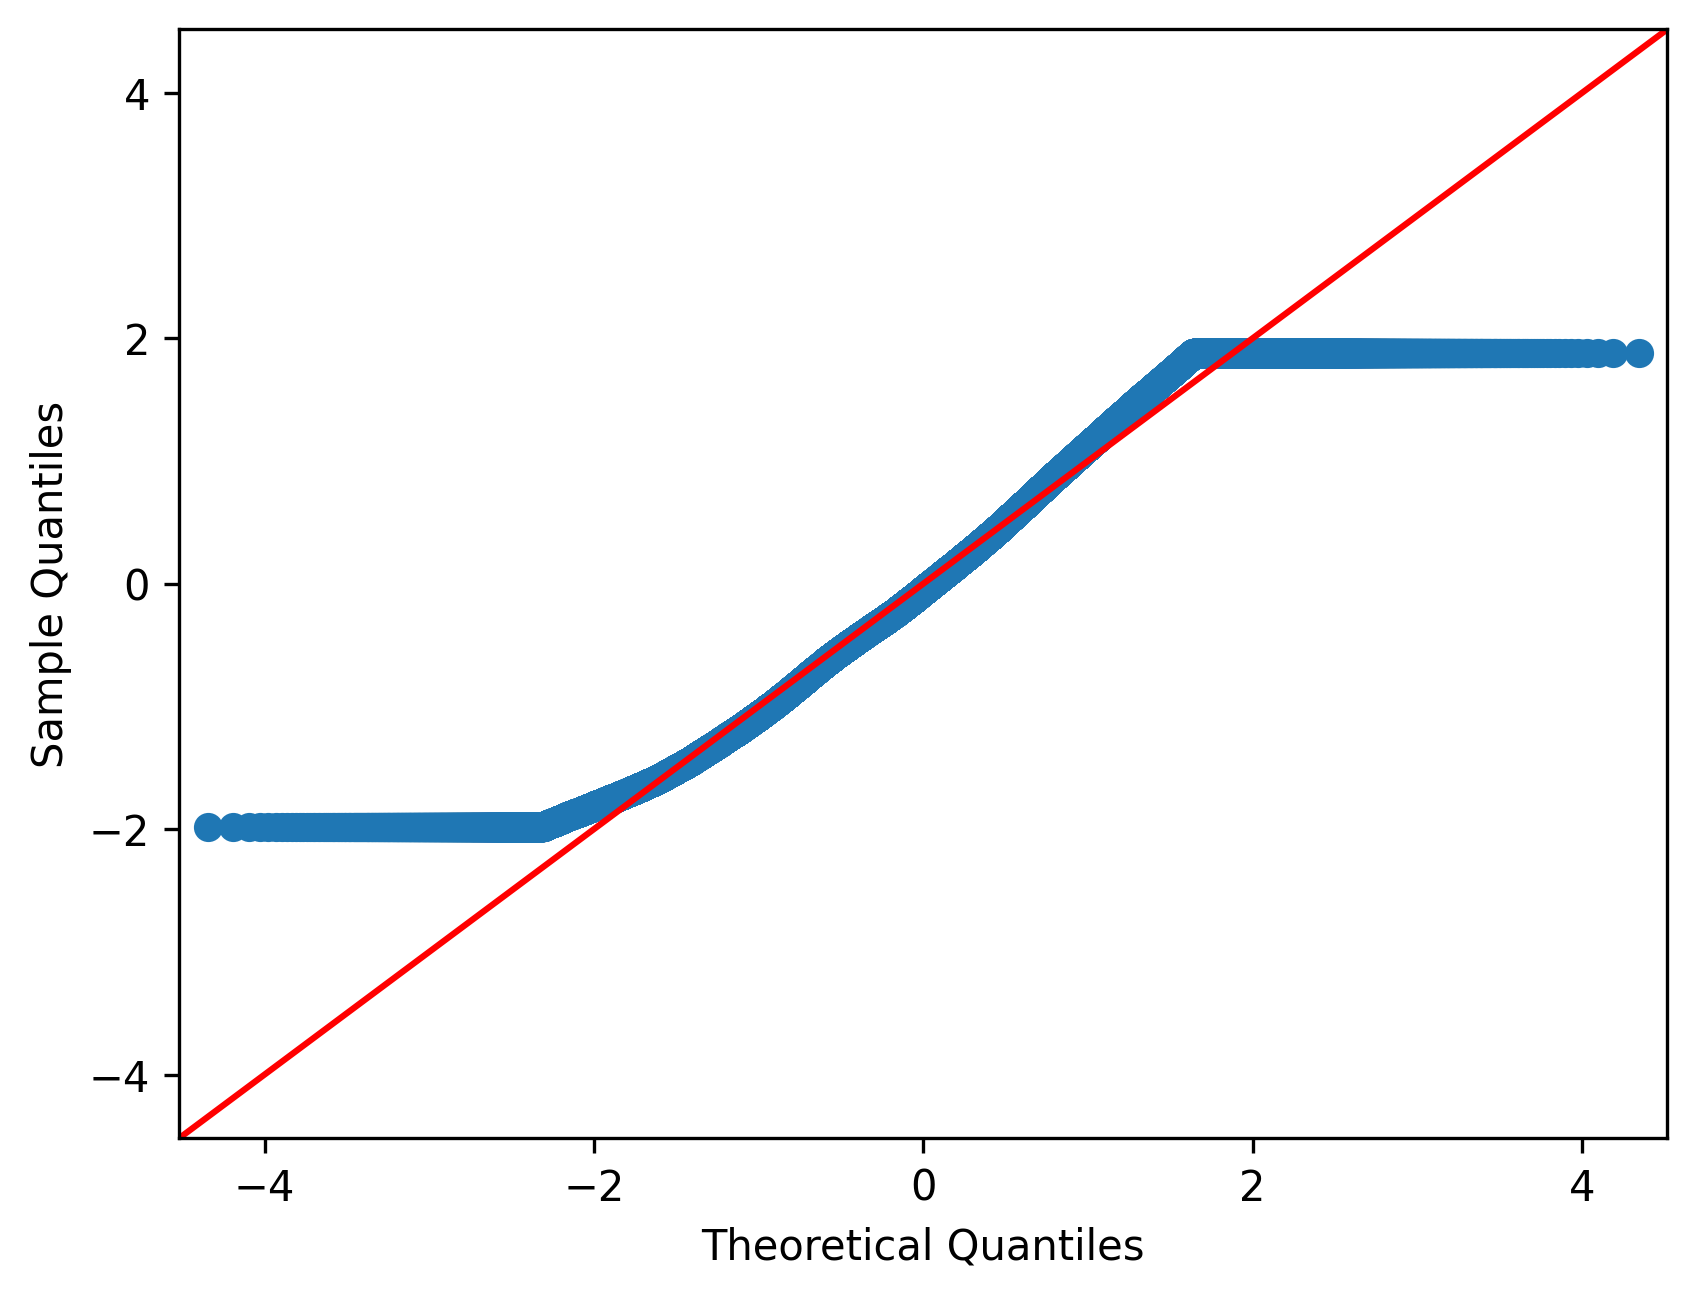

In [20]:
plot = sm.qqplot(df['PJMW_MW'],line = "45", fit=True)

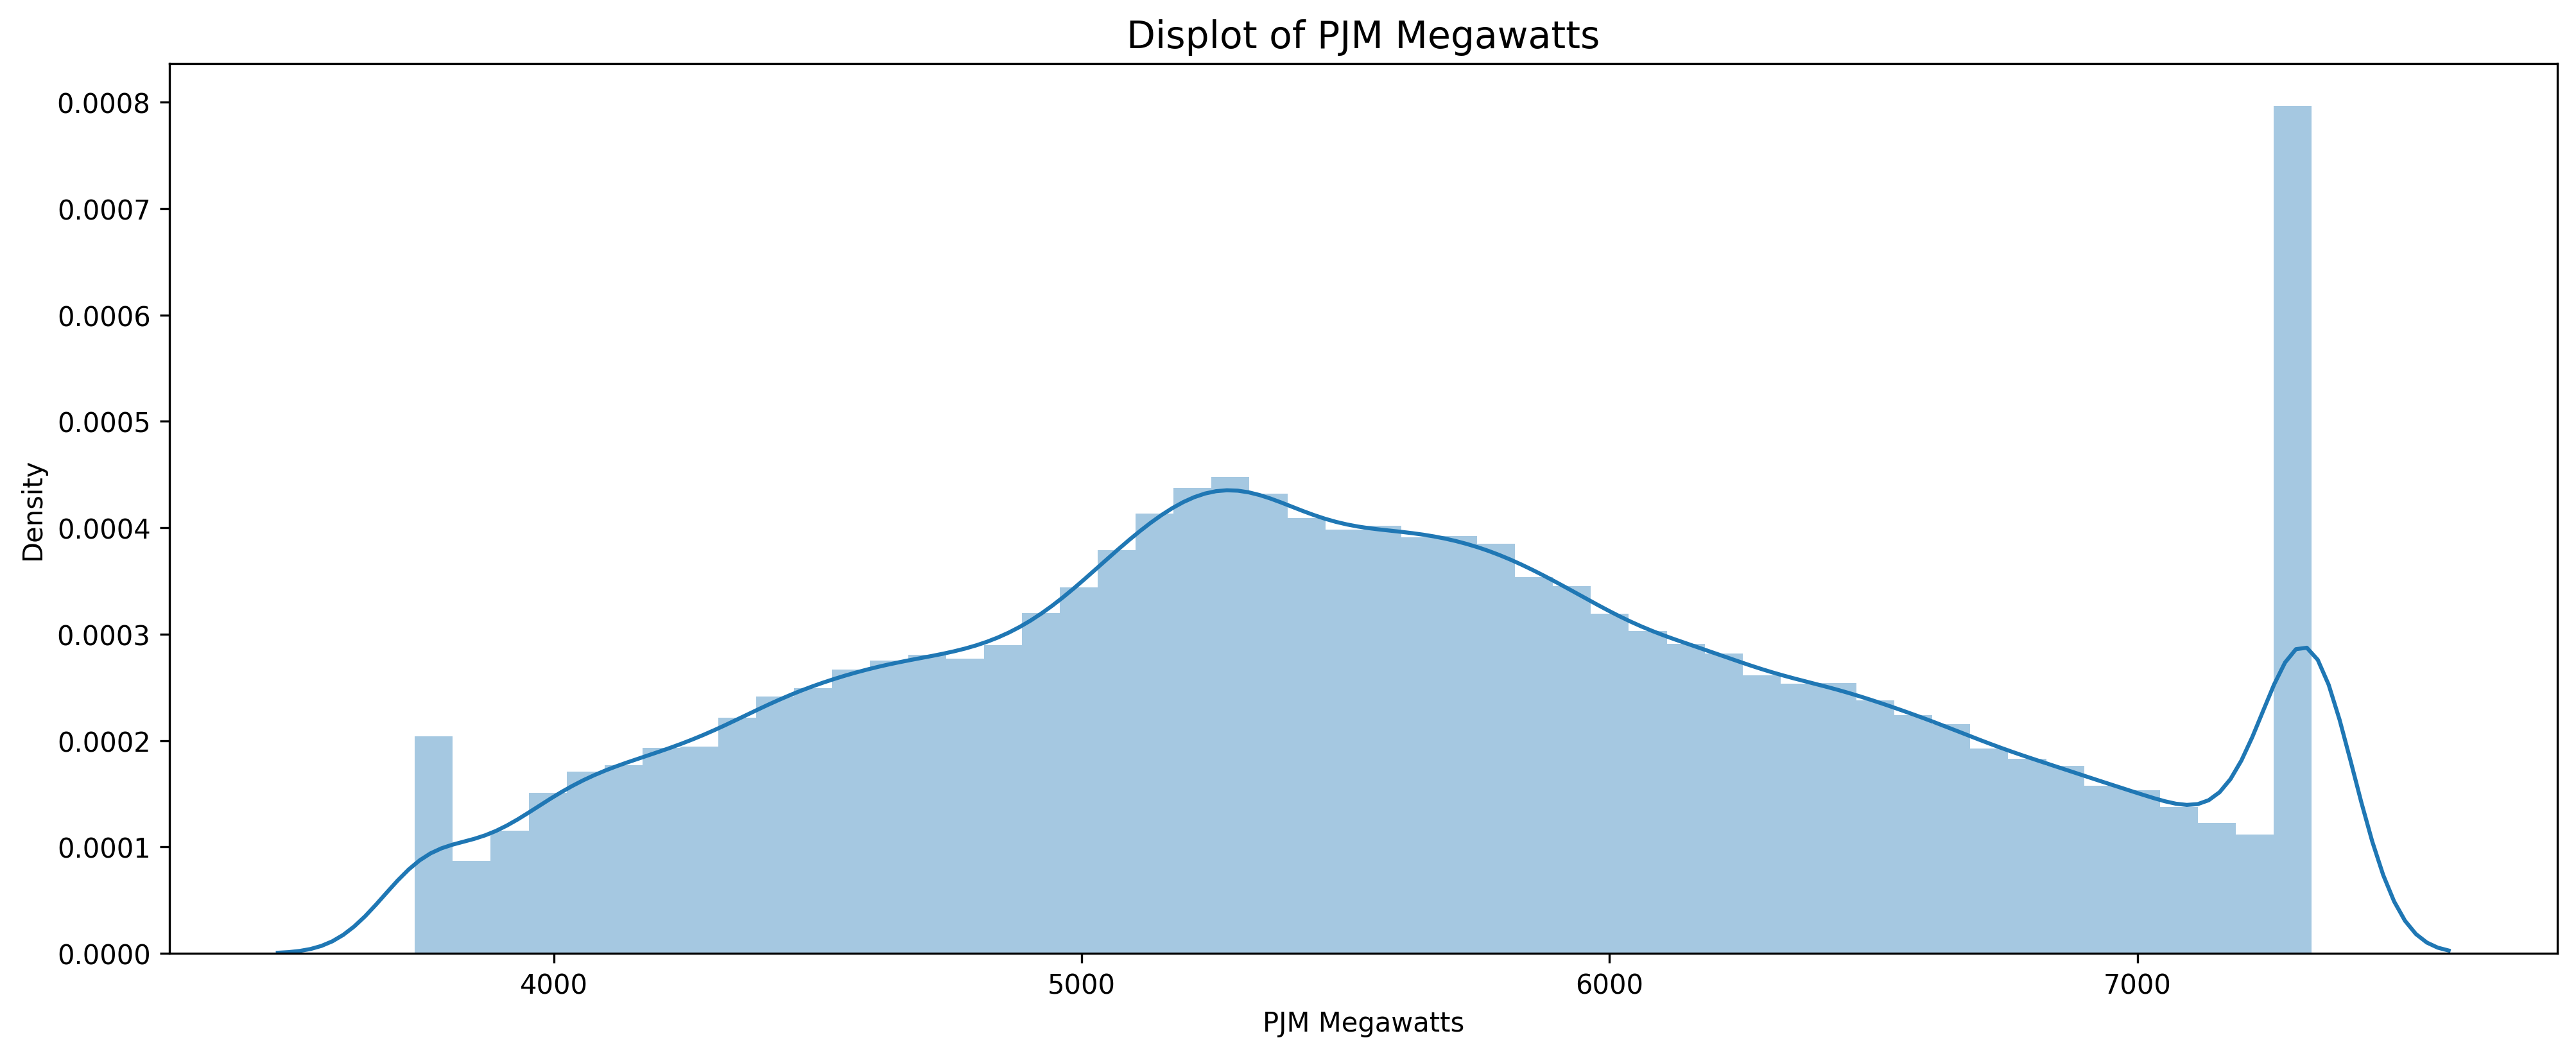

In [21]:
# line plot

plt.figure(figsize=(16,6))
sns.distplot(df['PJMW_MW'])
plt.title('Displot of PJM Megawatts',fontdict={'fontsize': 14,'color': 'black'})
plt.xlabel('PJM Megawatts')
plt.show()

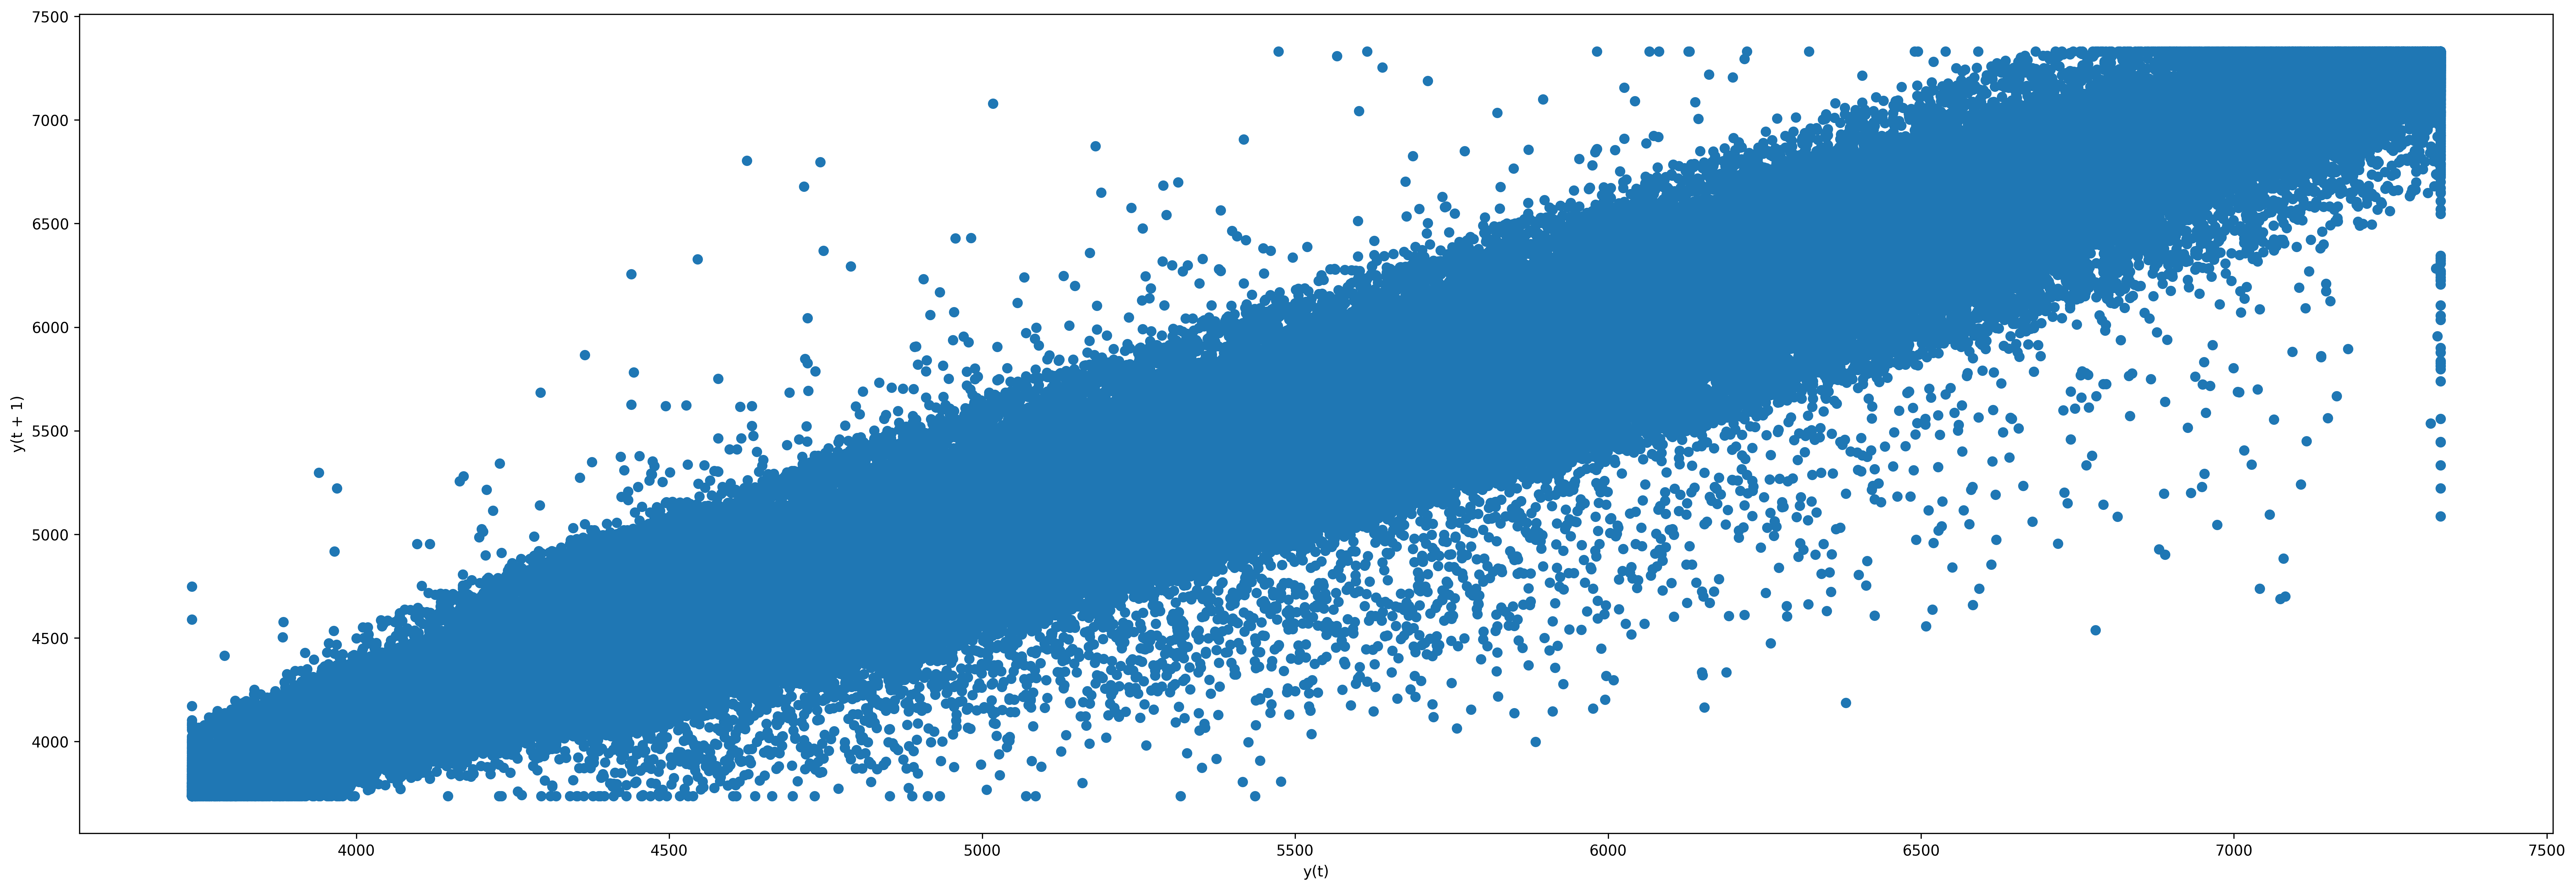

In [22]:
from pandas.plotting import lag_plot
plt.figure(figsize=(30,10))
lag_plot(df["PJMW_MW"])
plt.show()

In [23]:
df['date']=df.index
df['hour']=df['date'].dt.hour
df['dayofweek']=df['date'].dt.dayofweek
df['quarter']=df['date'].dt.quarter
df["month"] = df.index.month
df["day"] = df['date'].dt.strftime("%d")
df['year']=df['date'].dt.year
df['dayofyear']=df['date'].dt.dayofyear
df['dayofmonth']=df['date'].dt.day
df['weekofyear']=df['date'].dt.weekofyear
df.drop(['date'], axis = 1, inplace=True)

In [24]:
df.head()

PJMW_MW  hour  dayofweek  quarter  month day  year  \
Datetime                                                                  
2002-12-31 01:00:00   5077.0     1          1        4     12  31  2002   
2002-12-31 02:00:00   4939.0     2          1        4     12  31  2002   
2002-12-31 03:00:00   4885.0     3          1        4     12  31  2002   
2002-12-31 04:00:00   4857.0     4          1        4     12  31  2002   
2002-12-31 05:00:00   4930.0     5          1        4     12  31  2002   

                     dayofyear  dayofmonth  weekofyear  
Datetime                                                
2002-12-31 01:00:00        365          31           1  
2002-12-31 02:00:00        365          31           1  
2002-12-31 03:00:00        365          31           1  
2002-12-31 04:00:00        365          31           1  
2002-12-31 05:00:00        365          31           1

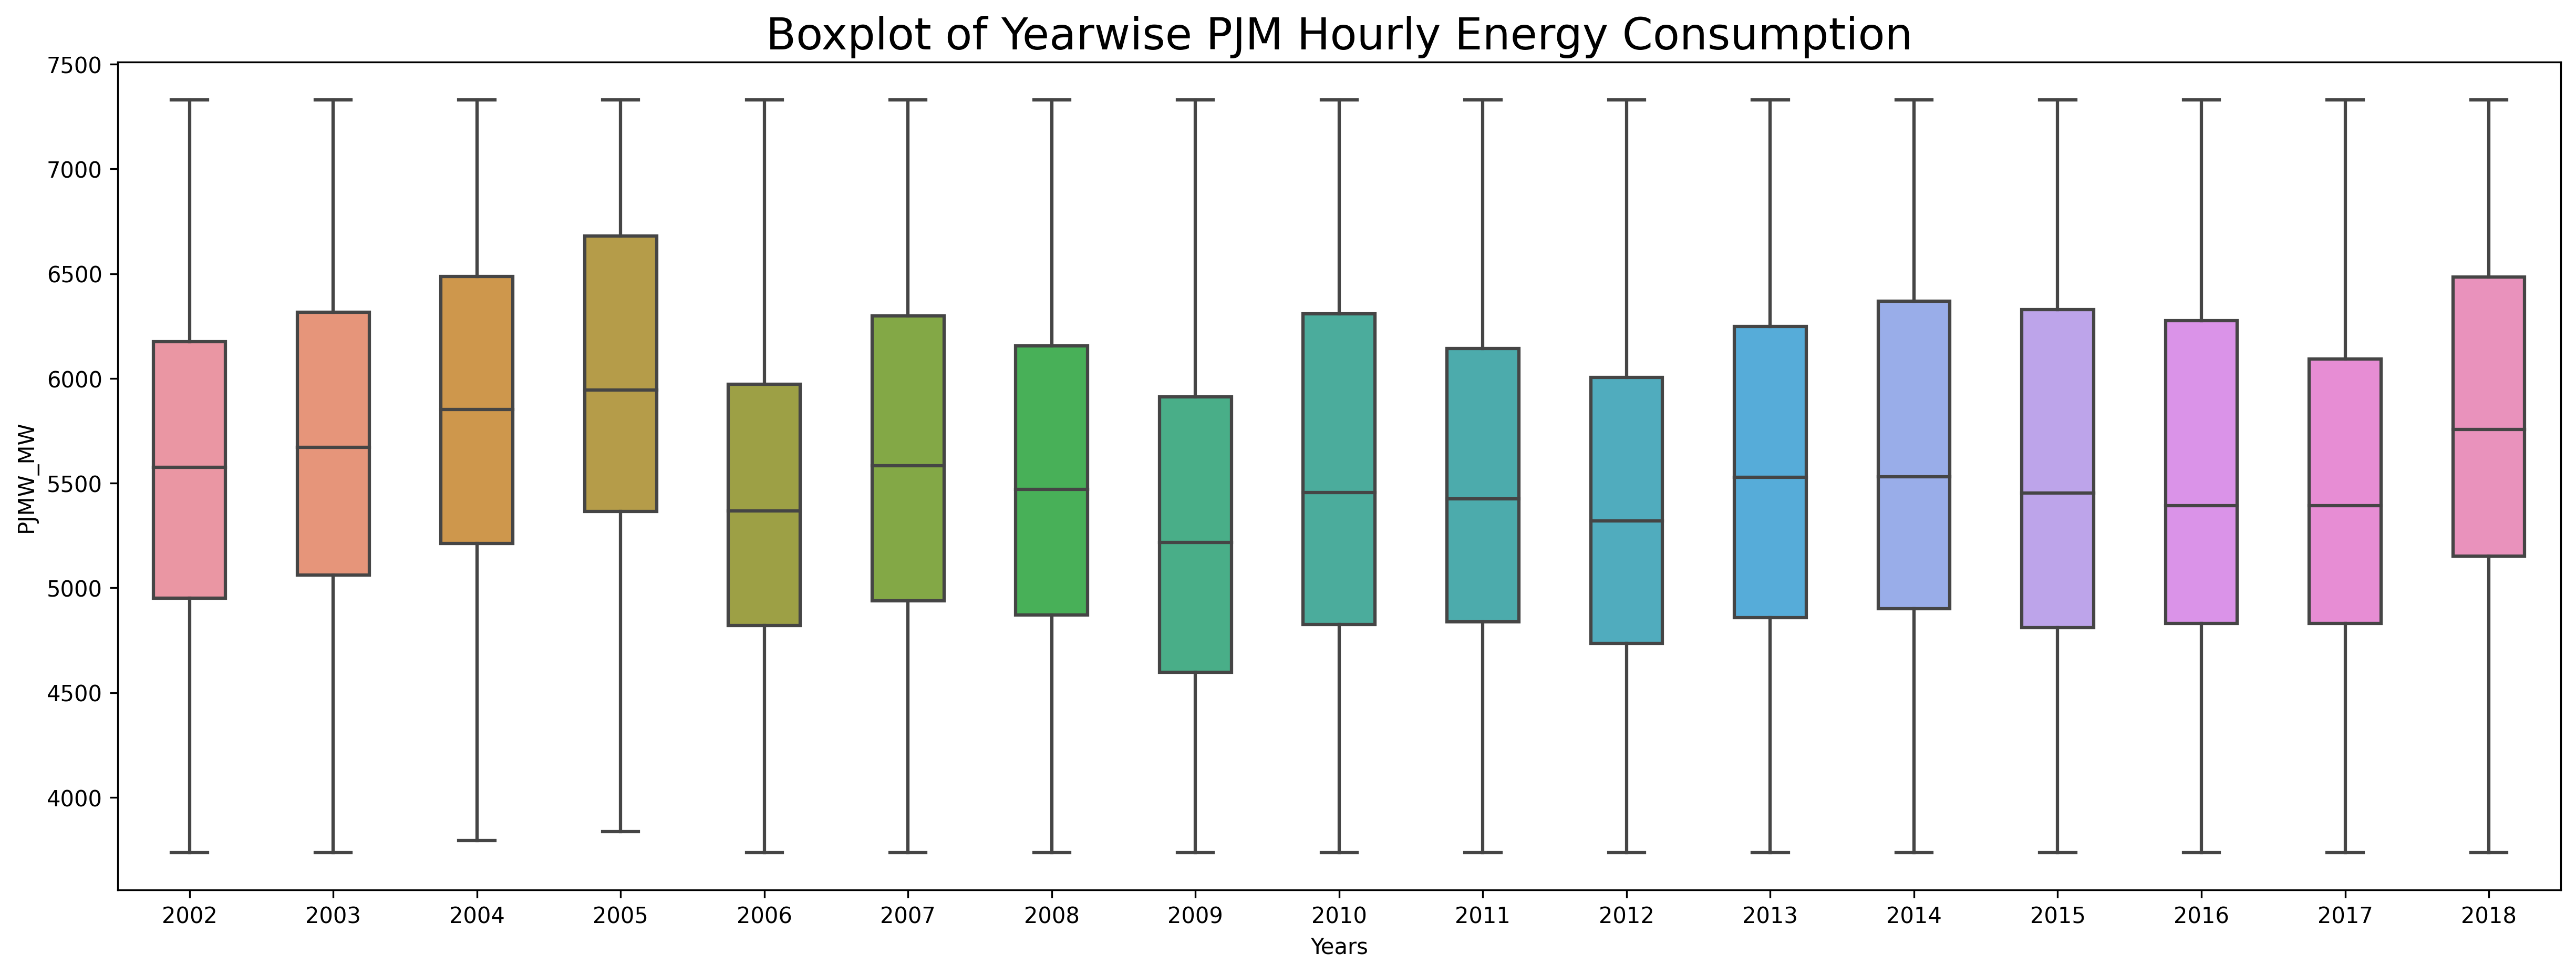

In [25]:
#Boxplot for year

plt.figure(figsize=(20,15))
plt.subplot(211)
sns.boxplot(x="year",y="PJMW_MW",data=df,width=0.5)
plt.title('Boxplot of Yearwise PJM Hourly Energy Consumption',fontdict={'fontsize': 20})
plt.xlabel('Years')
plt.show()

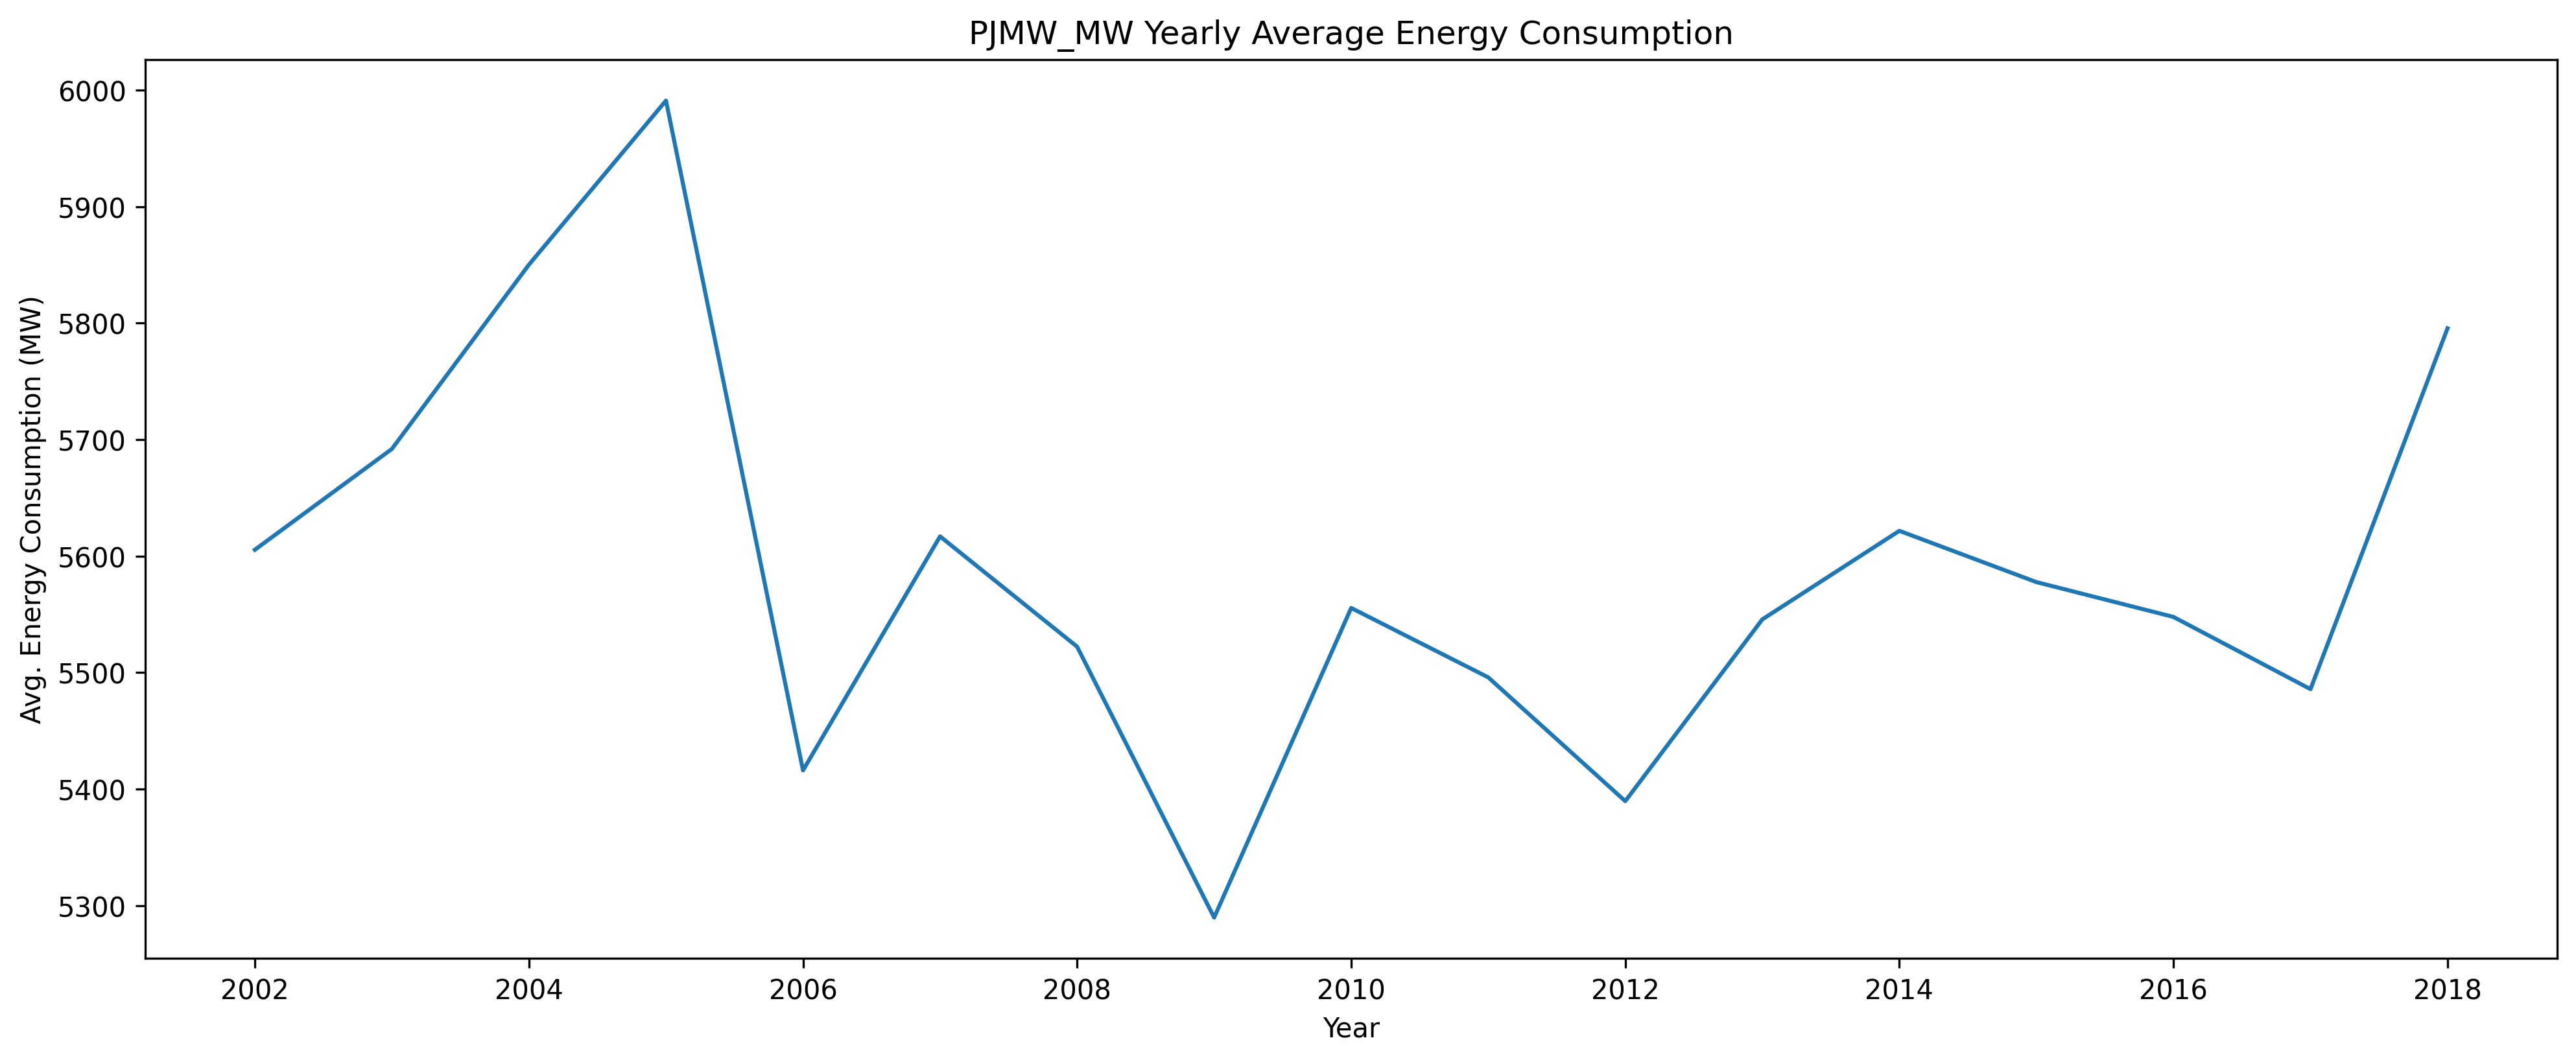

In [26]:
#Yearwise Trend

plt.figure(figsize=(16,6))
sns.lineplot(data=df.groupby('year').mean(),x='year',y='PJMW_MW')
plt.title('PJMW_MW Yearly Average Energy Consumption', fontsize=12)
plt.xlabel('Year')
plt.ylabel('Avg. Energy Consumption (MW)')
plt.show()

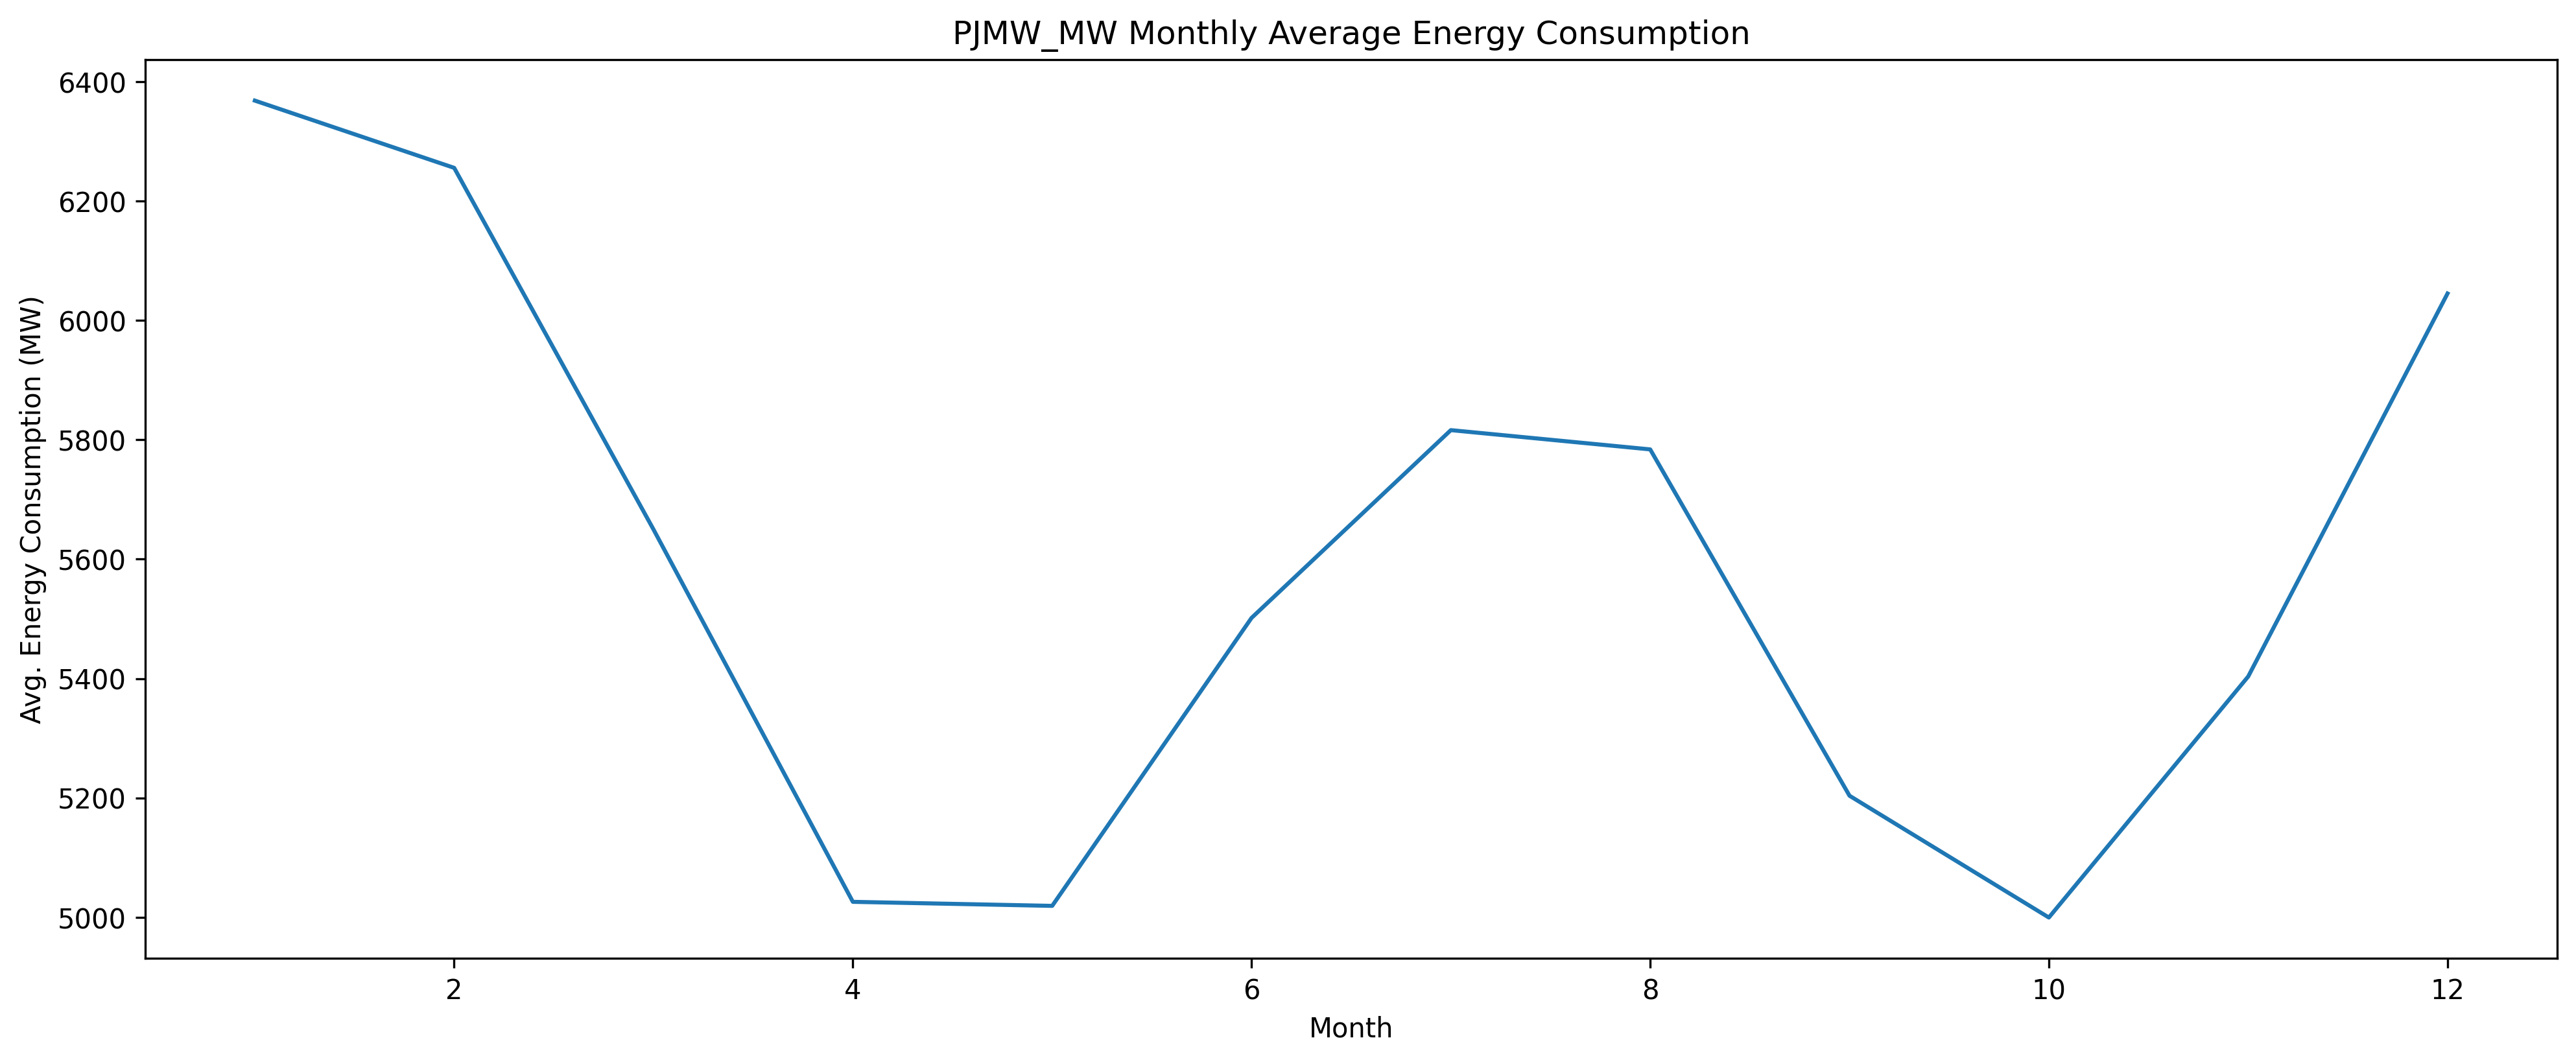

In [27]:
#Month wise trend

plt.figure(figsize=(16,6))
sns.lineplot(data=df.groupby('month').mean(),x='month',y='PJMW_MW')
plt.title('PJMW_MW Monthly Average Energy Consumption', fontsize=12)
plt.xlabel('Month')
plt.ylabel('Avg. Energy Consumption (MW)')
plt.show()

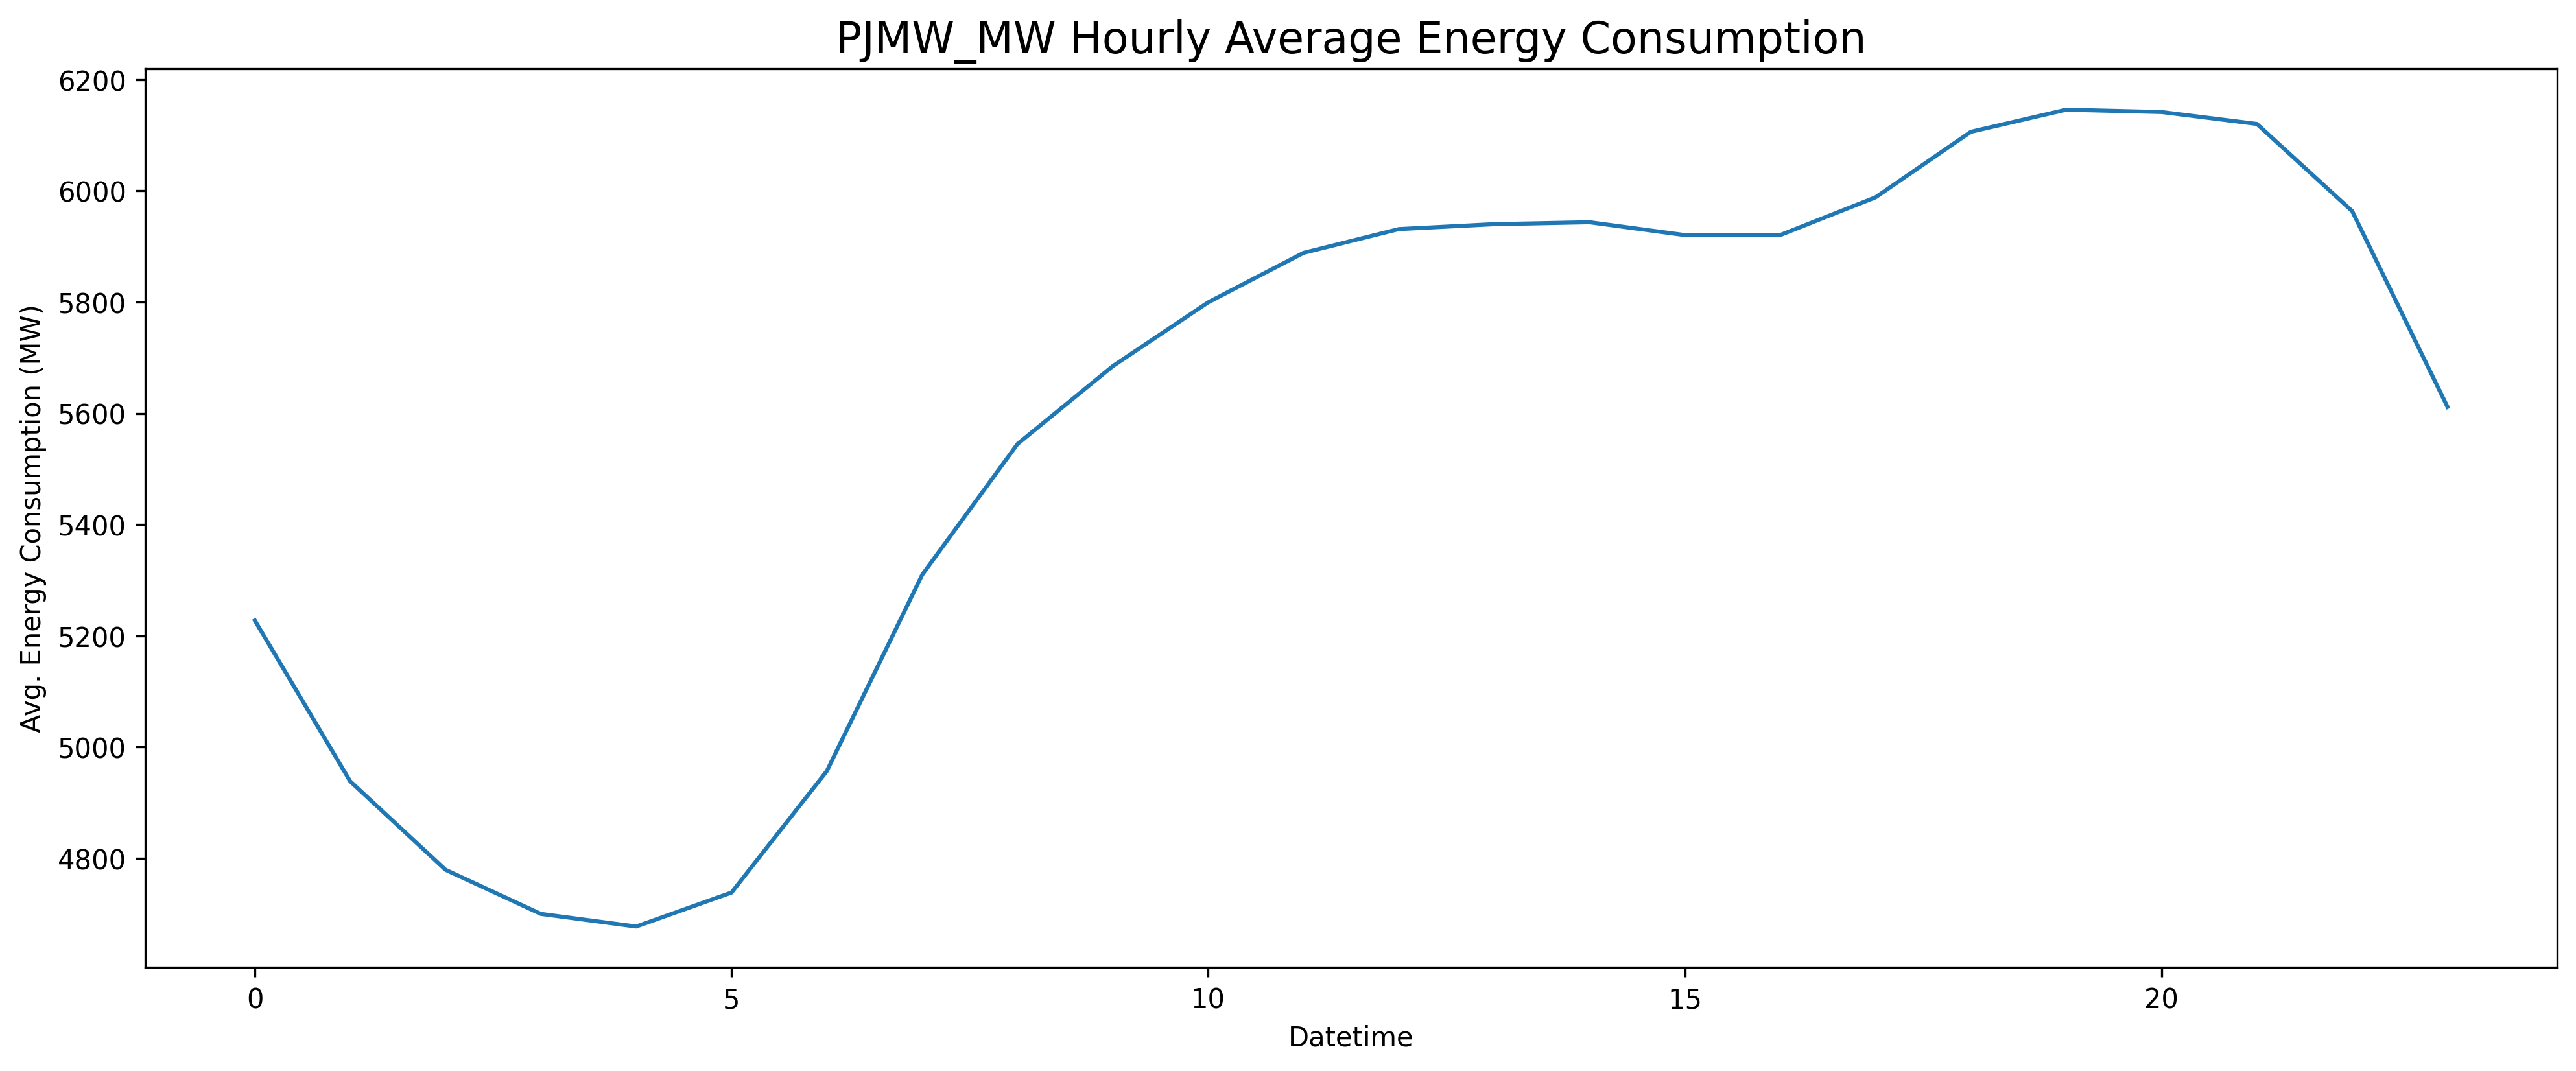

In [28]:
#Hourly Trend

plt.figure(figsize=(16,6))
sns.lineplot(data=df.groupby('hour').mean(),x='hour',y='PJMW_MW')
plt.title('PJMW_MW Hourly Average Energy Consumption', fontsize=16)
plt.xlabel('Datetime')
plt.ylabel('Avg. Energy Consumption (MW)')
plt.show()

<AxesSubplot: xlabel='day', ylabel='PJMW_MW'>

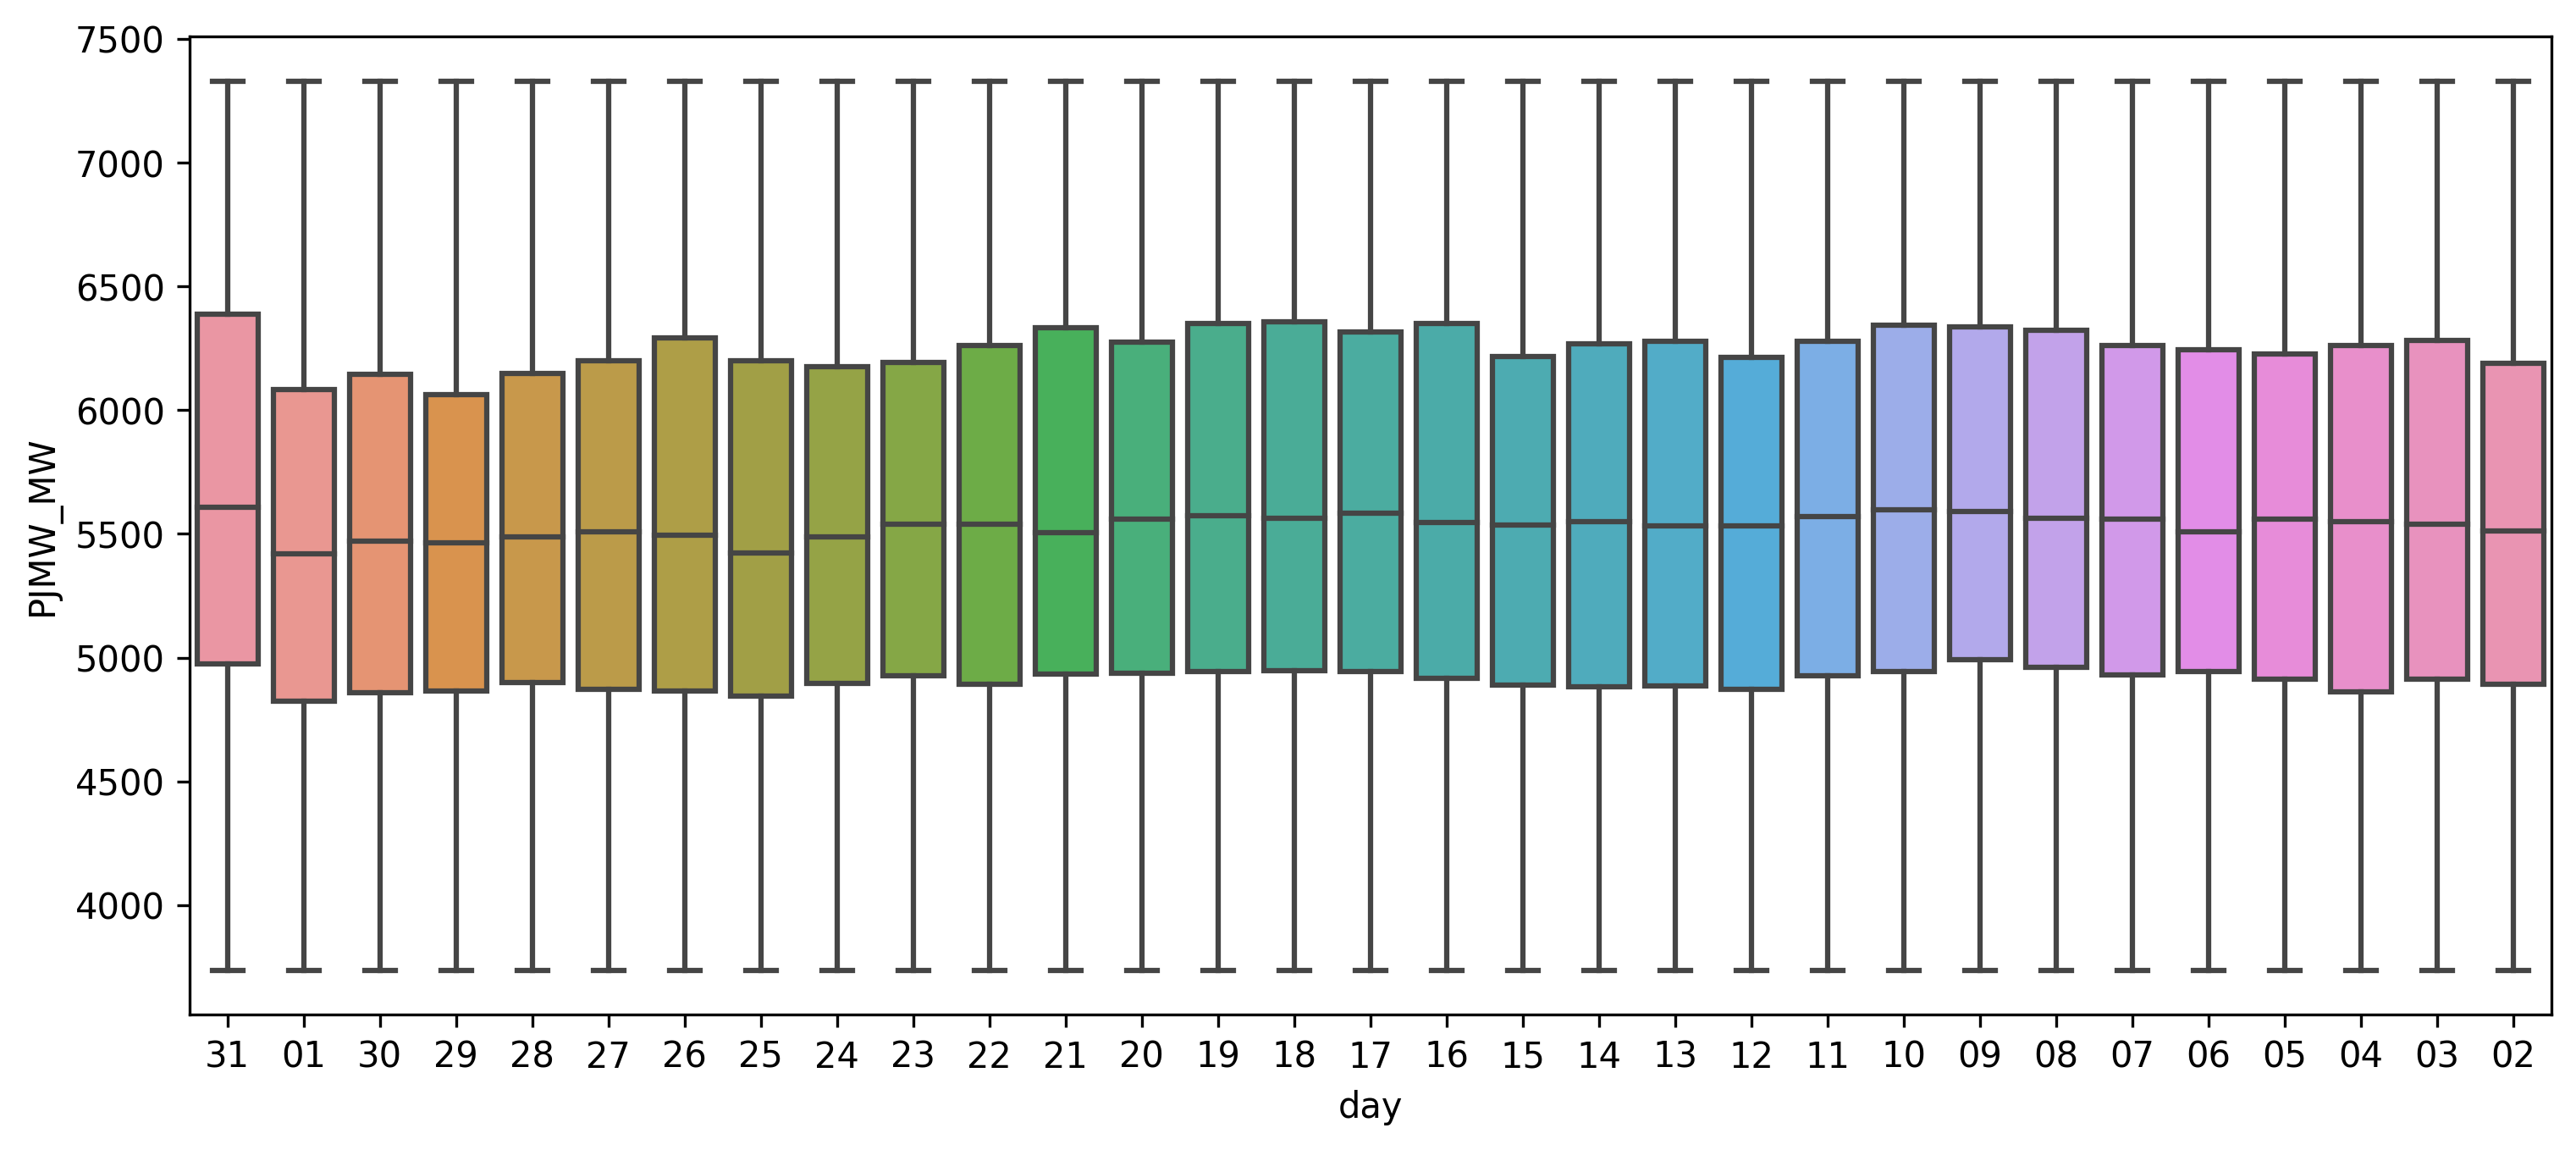

In [29]:
#Daily Trend

fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = df.day,
                y = df['PJMW_MW'],
                ax = ax)

<AxesSubplot: xlabel='year', ylabel='month'>

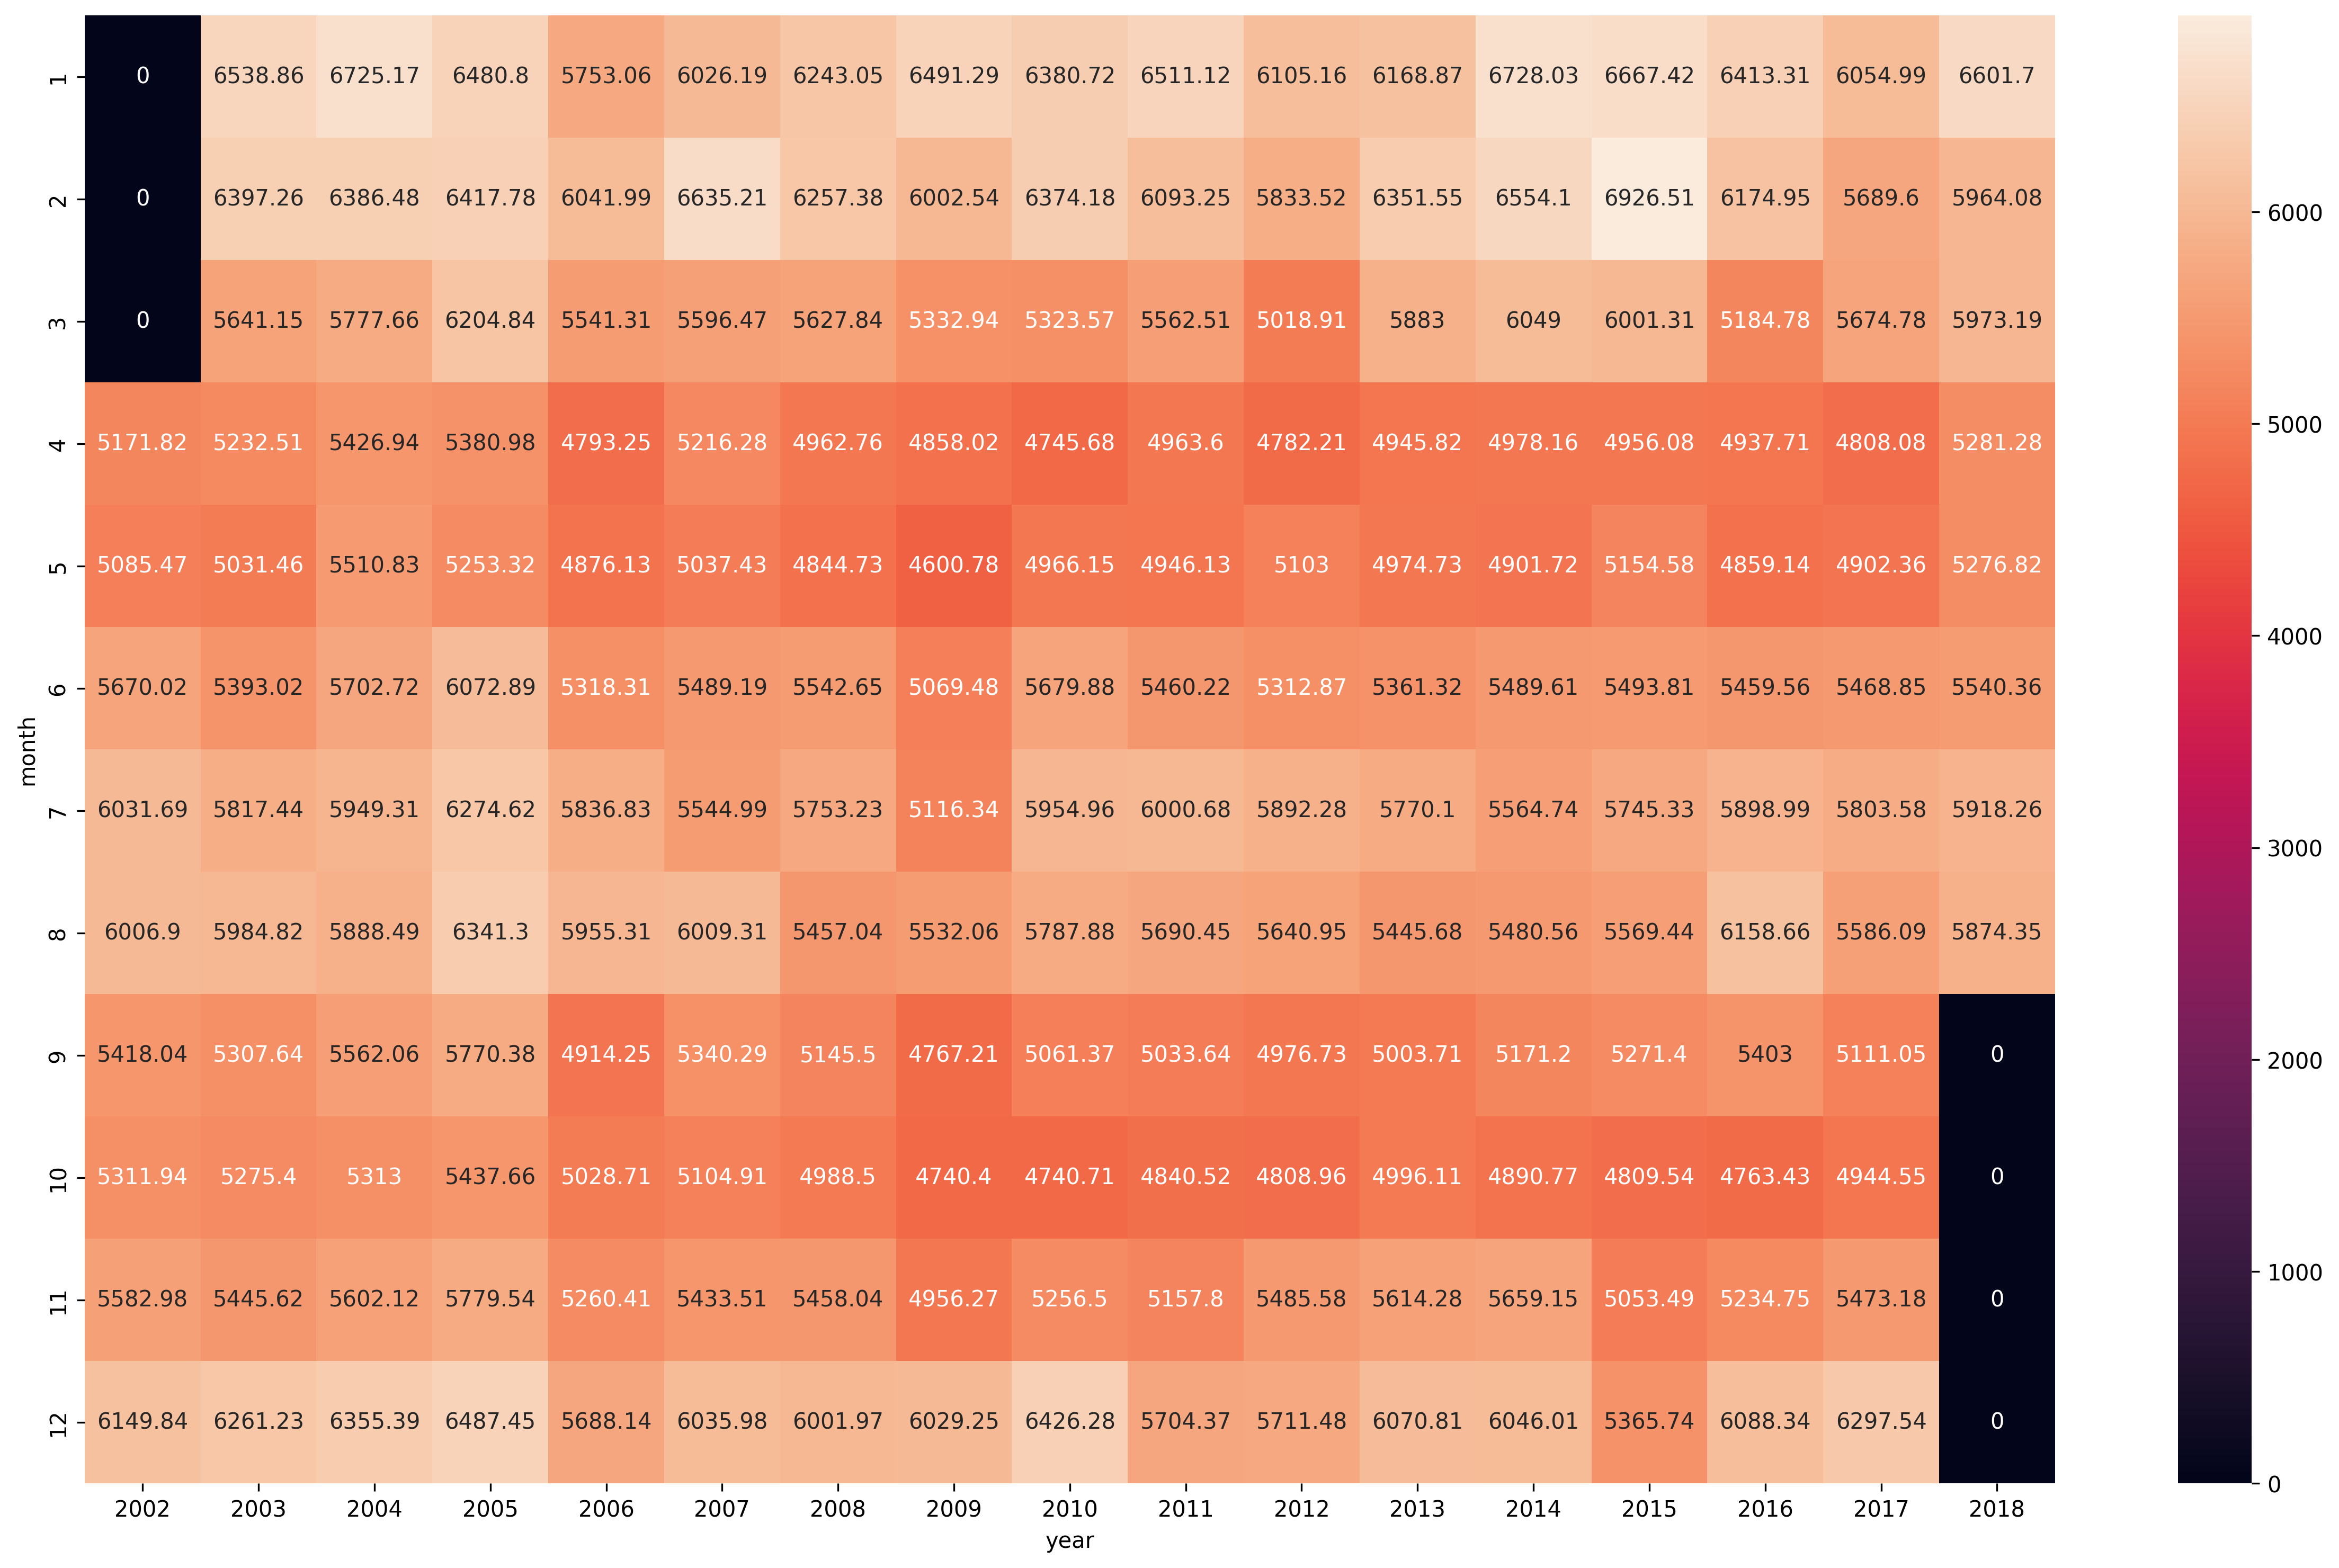

In [30]:
#Heatmap of Energy Consumption of Each Year with Month

plt.figure(figsize=(20,12))
heatmap_y_month = pd.pivot_table(data=df,values="PJMW_MW",index="month",columns="year",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

# Train_Test split

In [31]:
#train test split mannually for time series
# train_data = df['PJMW_MW'].head(138071)
# test_data= df['PJMW_MW'].tail(5135)

train=df.loc[df.year < 2018]
test = df.loc[df.year >= 2018]

In [32]:
train.shape

(138070, 10)

In [33]:
test.shape

(5136, 10)

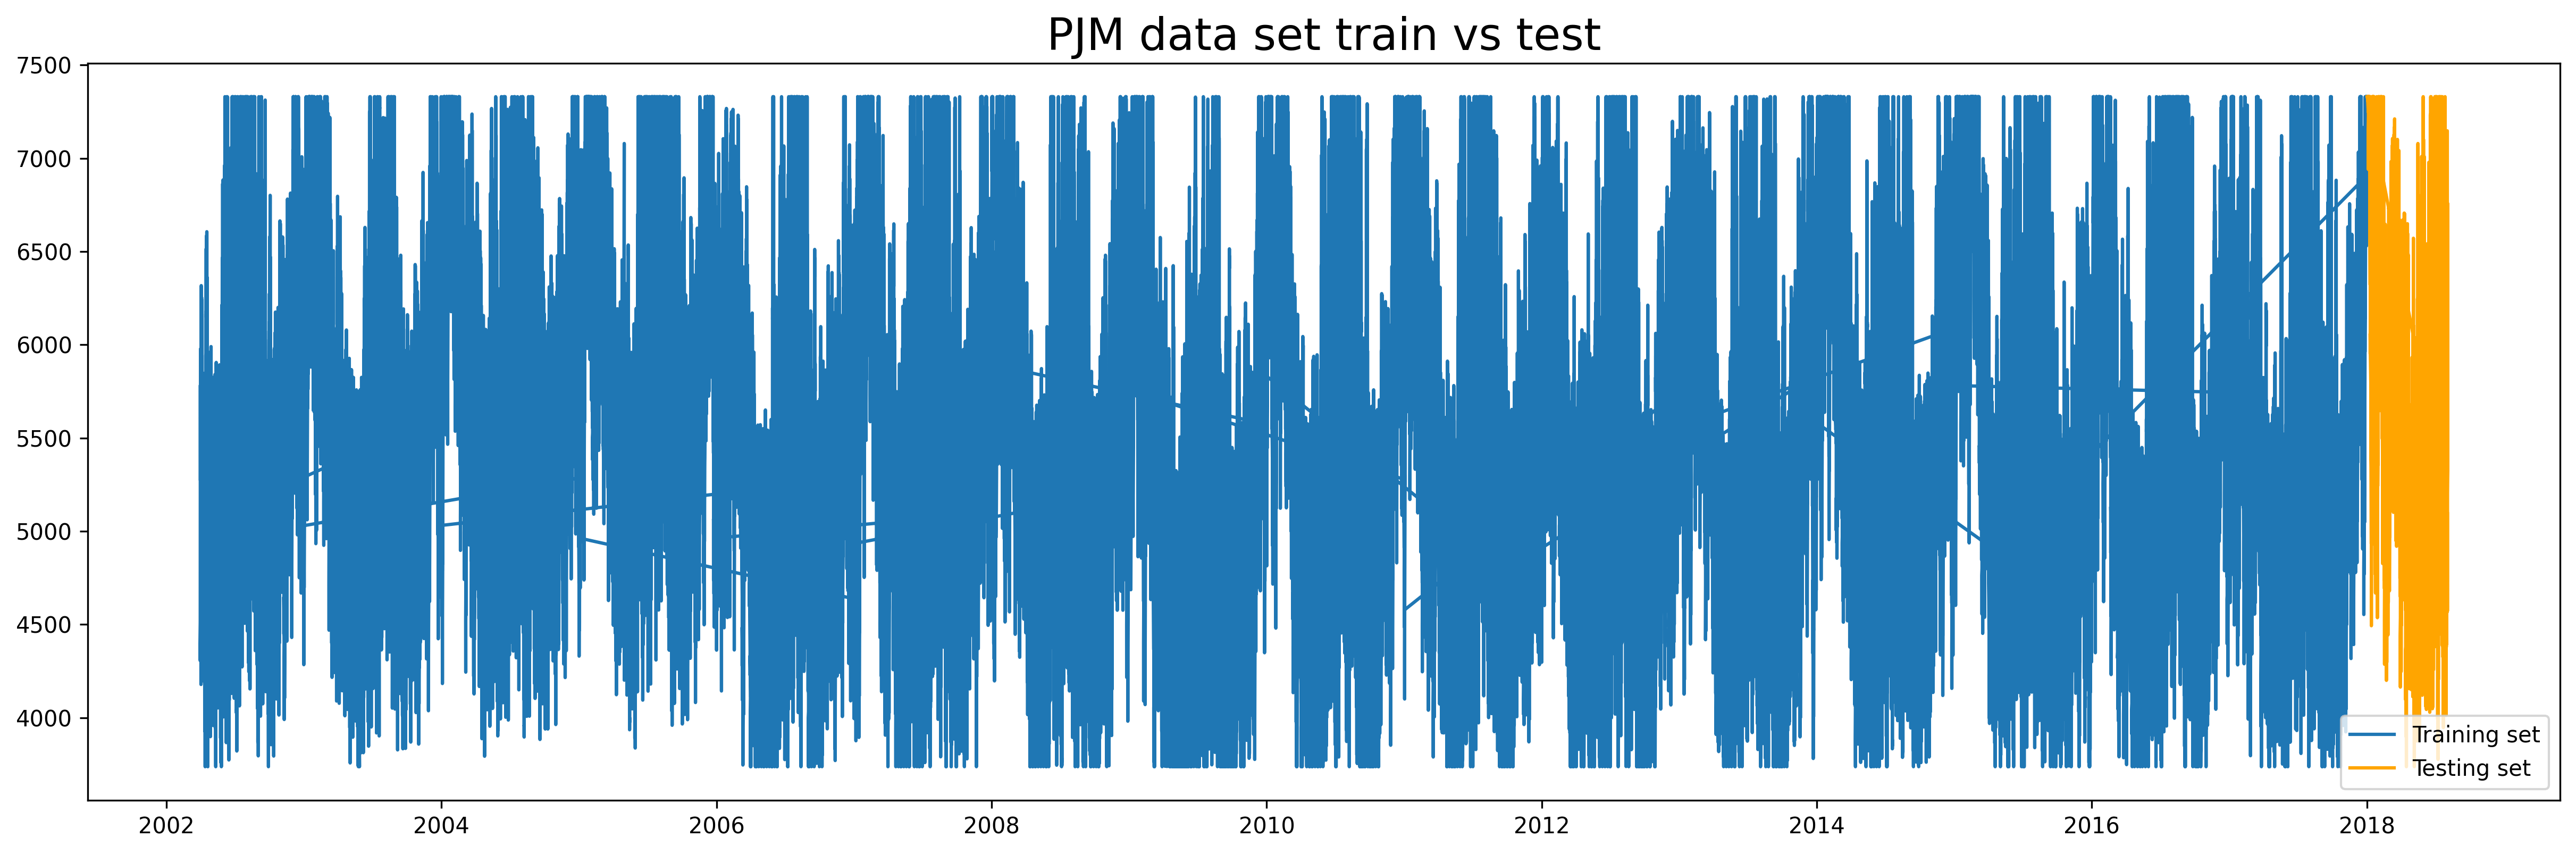

In [34]:
#Train-Test split

import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.title('PJM data set train vs test',size=20)
plt.plot(train['PJMW_MW'],label='Training set')
plt.plot(test['PJMW_MW'],label='Testing set',color='orange')
plt.legend()
plt.show()

# Model Building

# XGBRegressor Model

In [35]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, plot_tree

In [36]:
xtrain = train[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
xtest = test[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
ytrain = train[['PJMW_MW']]
ytest = test[['PJMW_MW']]

In [37]:
xtrain

hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2002-12-31 01:00:00     1          1        4     12  2002        365   
2002-12-31 02:00:00     2          1        4     12  2002        365   
2002-12-31 03:00:00     3          1        4     12  2002        365   
2002-12-31 04:00:00     4          1        4     12  2002        365   
2002-12-31 05:00:00     5          1        4     12  2002        365   
...                   ...        ...      ...    ...   ...        ...   
2017-01-01 20:00:00    20          6        1      1  2017          1   
2017-01-01 21:00:00    21          6        1      1  2017          1   
2017-01-01 22:00:00    22          6        1      1  2017          1   
2017-01-01 23:00:00    23          6        1      1  2017          1   
2017-01-02 00:00:00     0          0        1      1  2017          2   

                     dayofmonth  weekofyear  
Datetime                                     
2002-12-31 01:00:00          31           1  
2002-12-31 02:00:00          31           1  
2002-12-31 03:00:00          31           1  
2002-12-31 04:00:00          31           1  
2002-12-31 05:00:00          31           1  
...                         ...         ...  
2017-01-01 20:00:00           1          52  
2017-01-01 21:00:00           1          52  
2017-01-01 22:00:00           1          52  
2017-01-01 23:00:00           1          52  
2017-01-02 00:00:00           2           1  

[138070 rows x 8 columns]

In [38]:
# create an xgboost regression model
xg_model = XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.03,
                        max_depth= 5, min_child_weight= 4,
                        n_estimators= 500, nthread= 4, objective= 'reg:linear', 
                        silent= 1, subsample= 0.7)
xg_model.fit(xtrain, ytrain,
       eval_set = [(xtrain, ytrain), (xtest, ytest)],
        early_stopping_rounds=50,
       verbose=100)

[22:12:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-rmse:5485.02335	validation_1-rmse:5701.66511
[100]	validation_0-rmse:552.02889	validation_1-rmse:766.67557
[200]	validation_0-rmse:431.13477	validation_1-rmse:612.40883
[300]	validation_0-rmse:407.14801	validation_1-rmse:609.02928
[314]	validation_0-rmse:404.53167	validation_1-rmse:609.80208


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, nthread=4, num_parallel_tree=None,
             objective='reg:linear', ...)

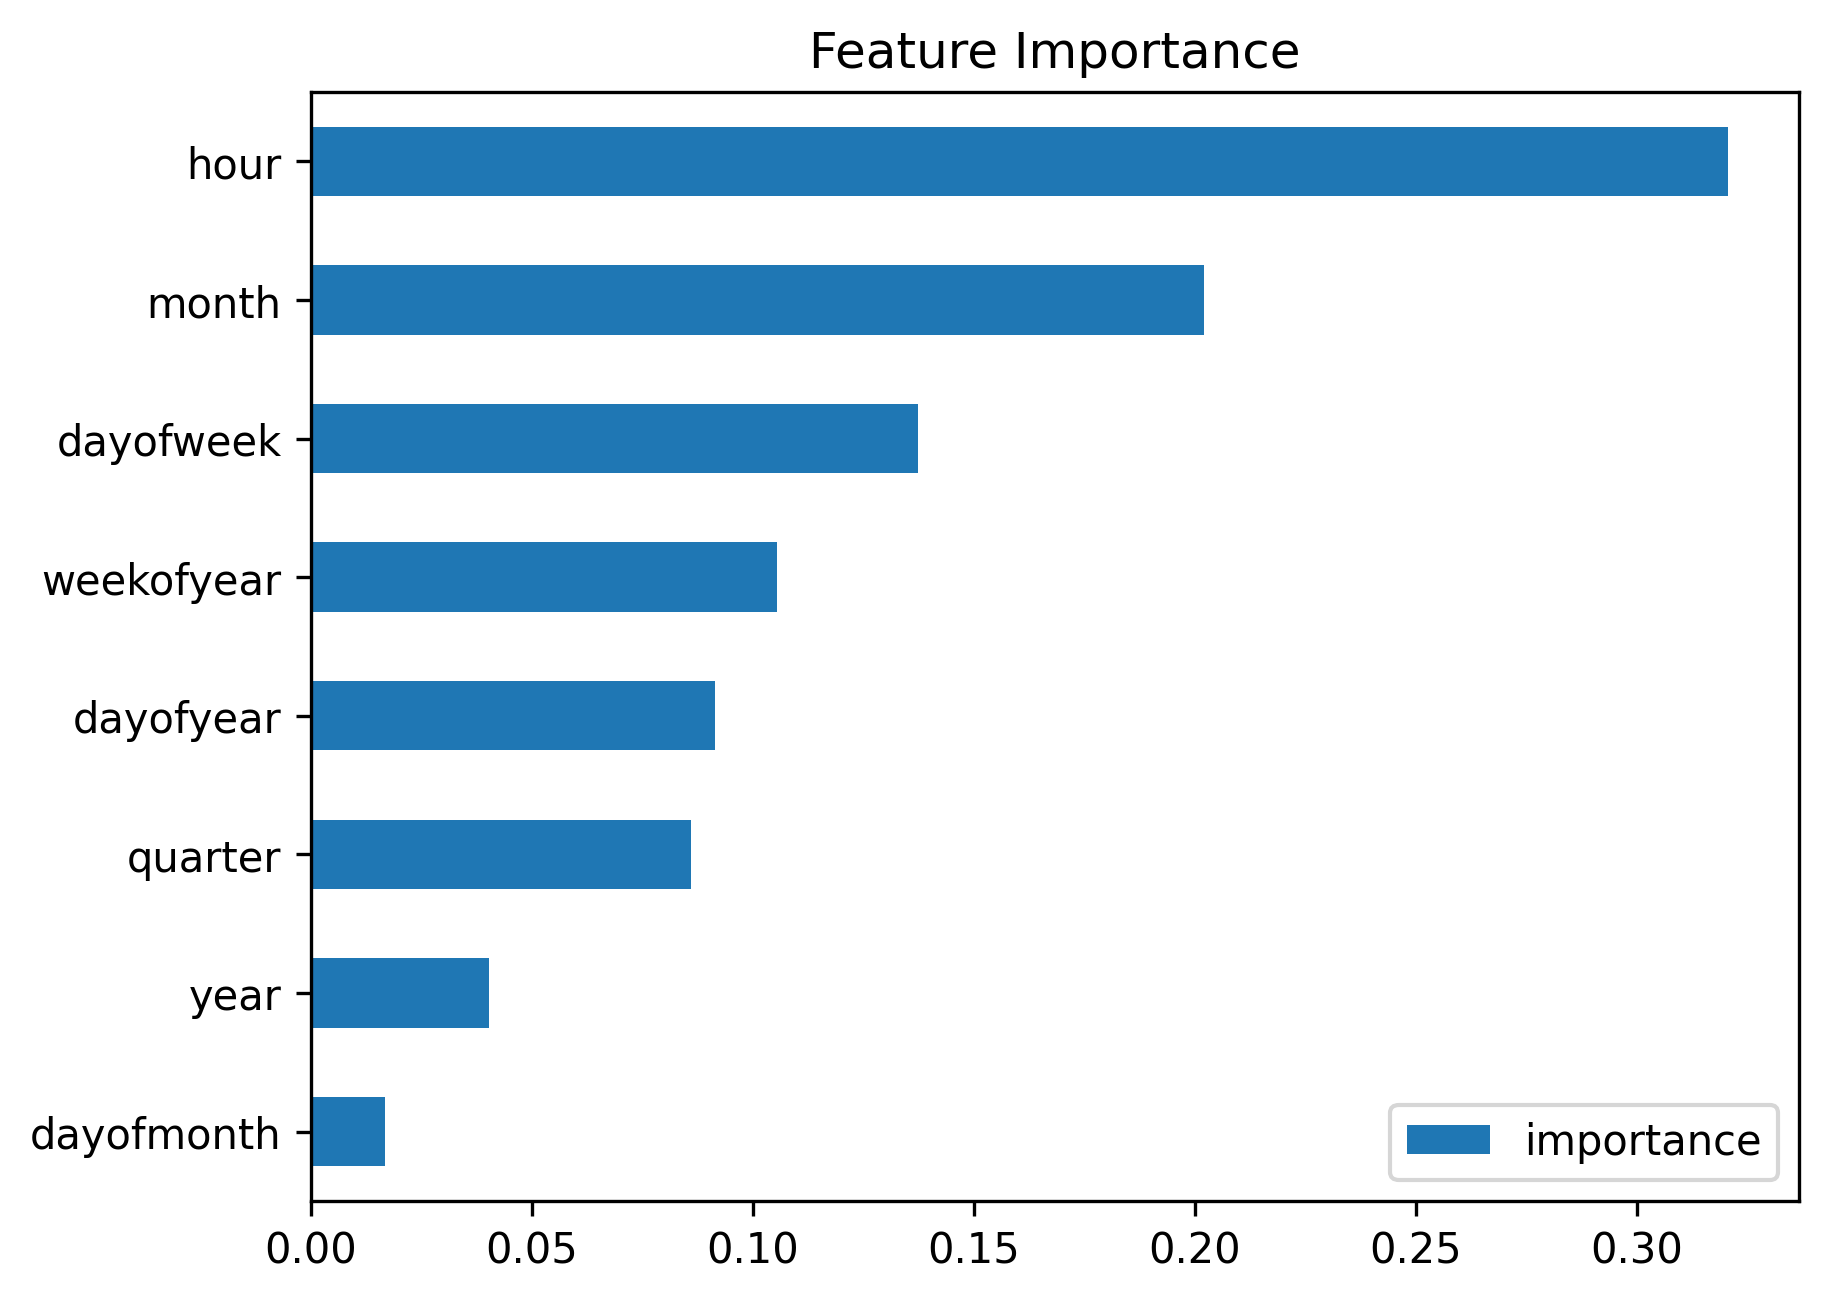

In [39]:
fi = pd.DataFrame(data=xg_model.feature_importances_,
             index=xg_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [40]:
test['Prediction'] = xg_model.predict(xtest)
pjme_all = pd.concat([test, train], sort=False)
test['Prediction']

Datetime
2018-01-01 00:00:00    4944.102539
2018-08-02 01:00:00    5067.413574
2018-08-02 02:00:00    4771.528320
2018-08-02 03:00:00    4623.778320
2018-08-02 04:00:00    4607.127441
                          ...     
2018-01-01 20:00:00    6115.134277
2018-01-01 21:00:00    6115.134277
2018-01-01 22:00:00    5983.982422
2018-01-01 23:00:00    5714.319824
2018-01-02 00:00:00    5526.087402
Name: Prediction, Length: 5136, dtype: float32

<AxesSubplot: xlabel='Datetime'>

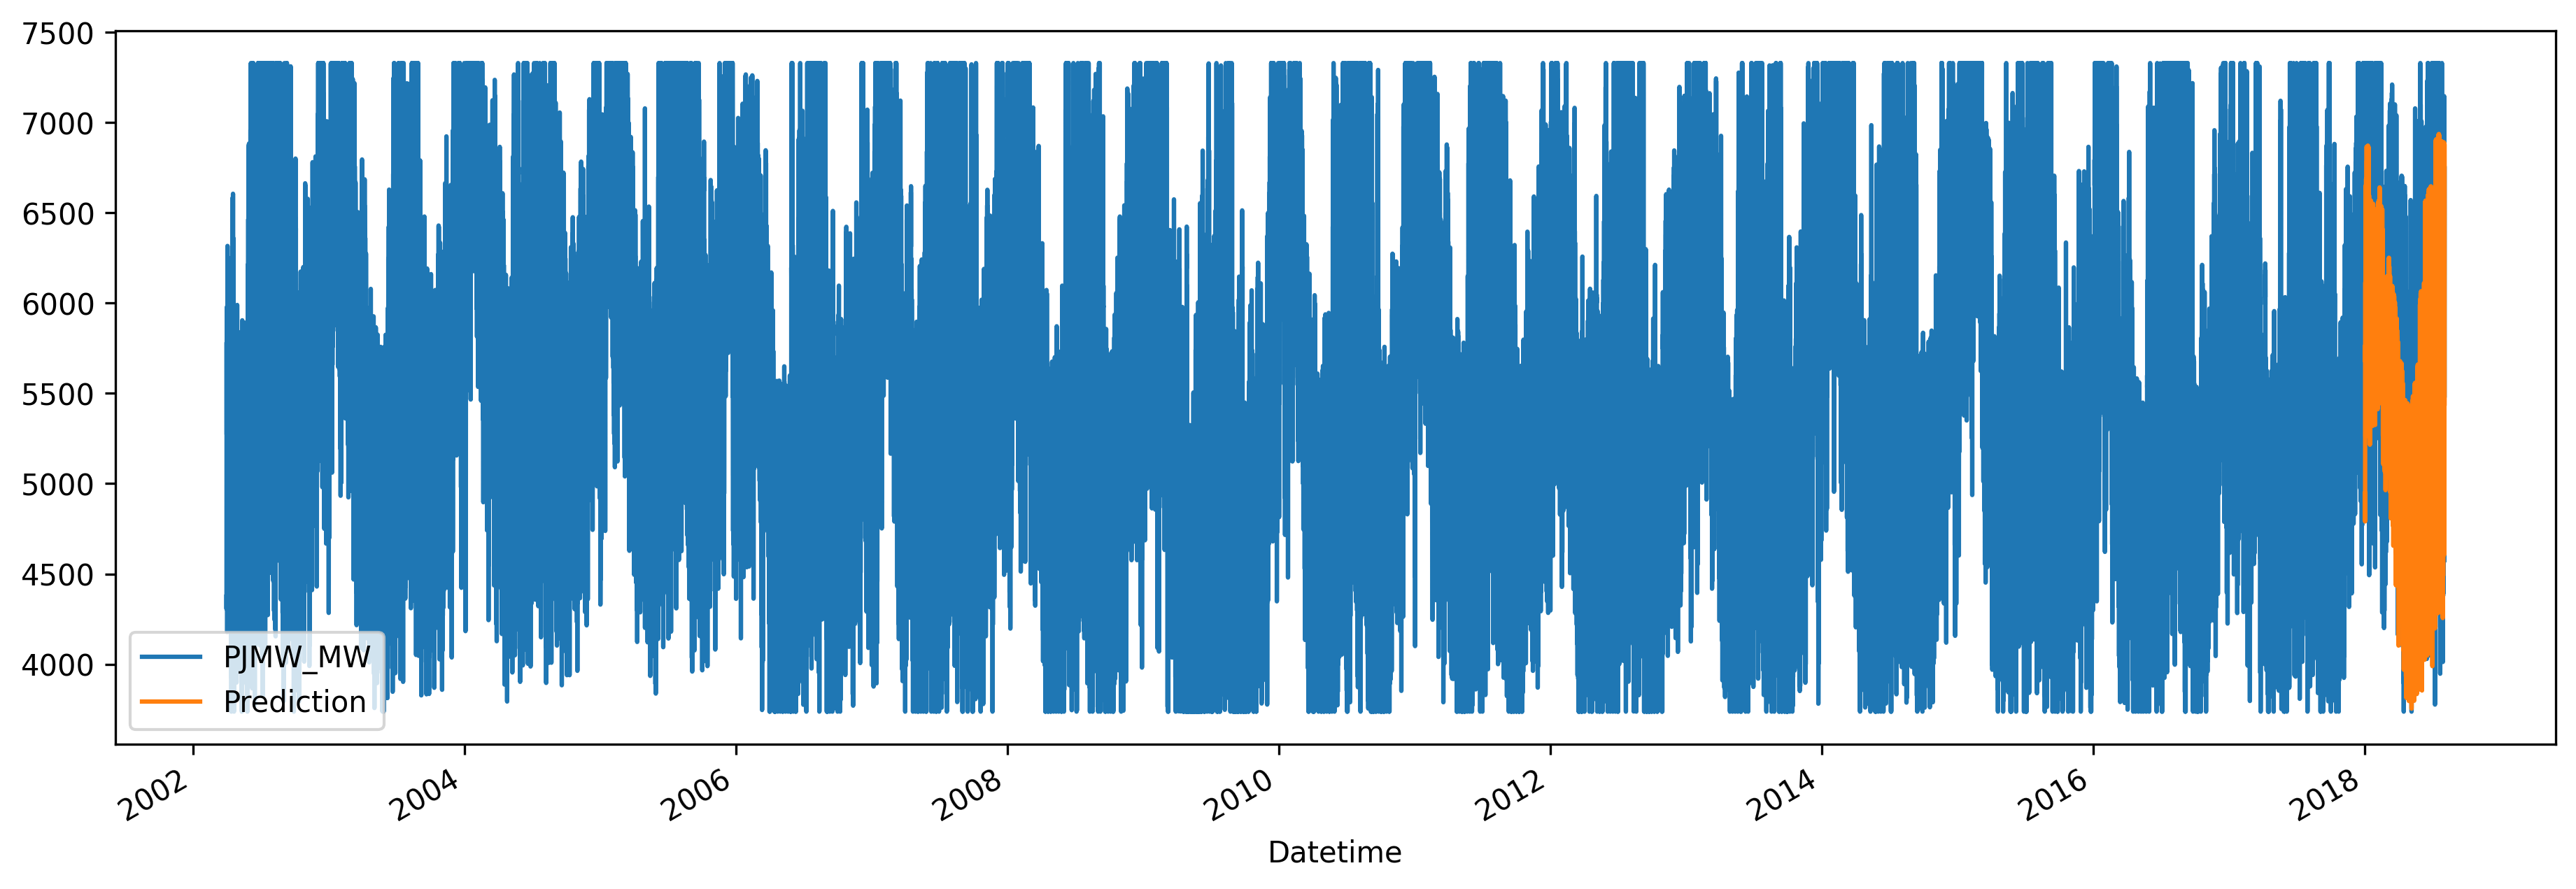

In [41]:
pjme_all[['PJMW_MW','Prediction']].plot(figsize=(15, 5))

In [42]:
xg_rmse = np.sqrt(mean_squared_error(y_true=test['PJMW_MW'],y_pred=test['Prediction']))
xg_rmse

605.9038943152034

In [43]:
xg_mbe = mean_absolute_error(y_true=test['PJMW_MW'], y_pred=test['Prediction'])
xg_mbe

470.20376743780116

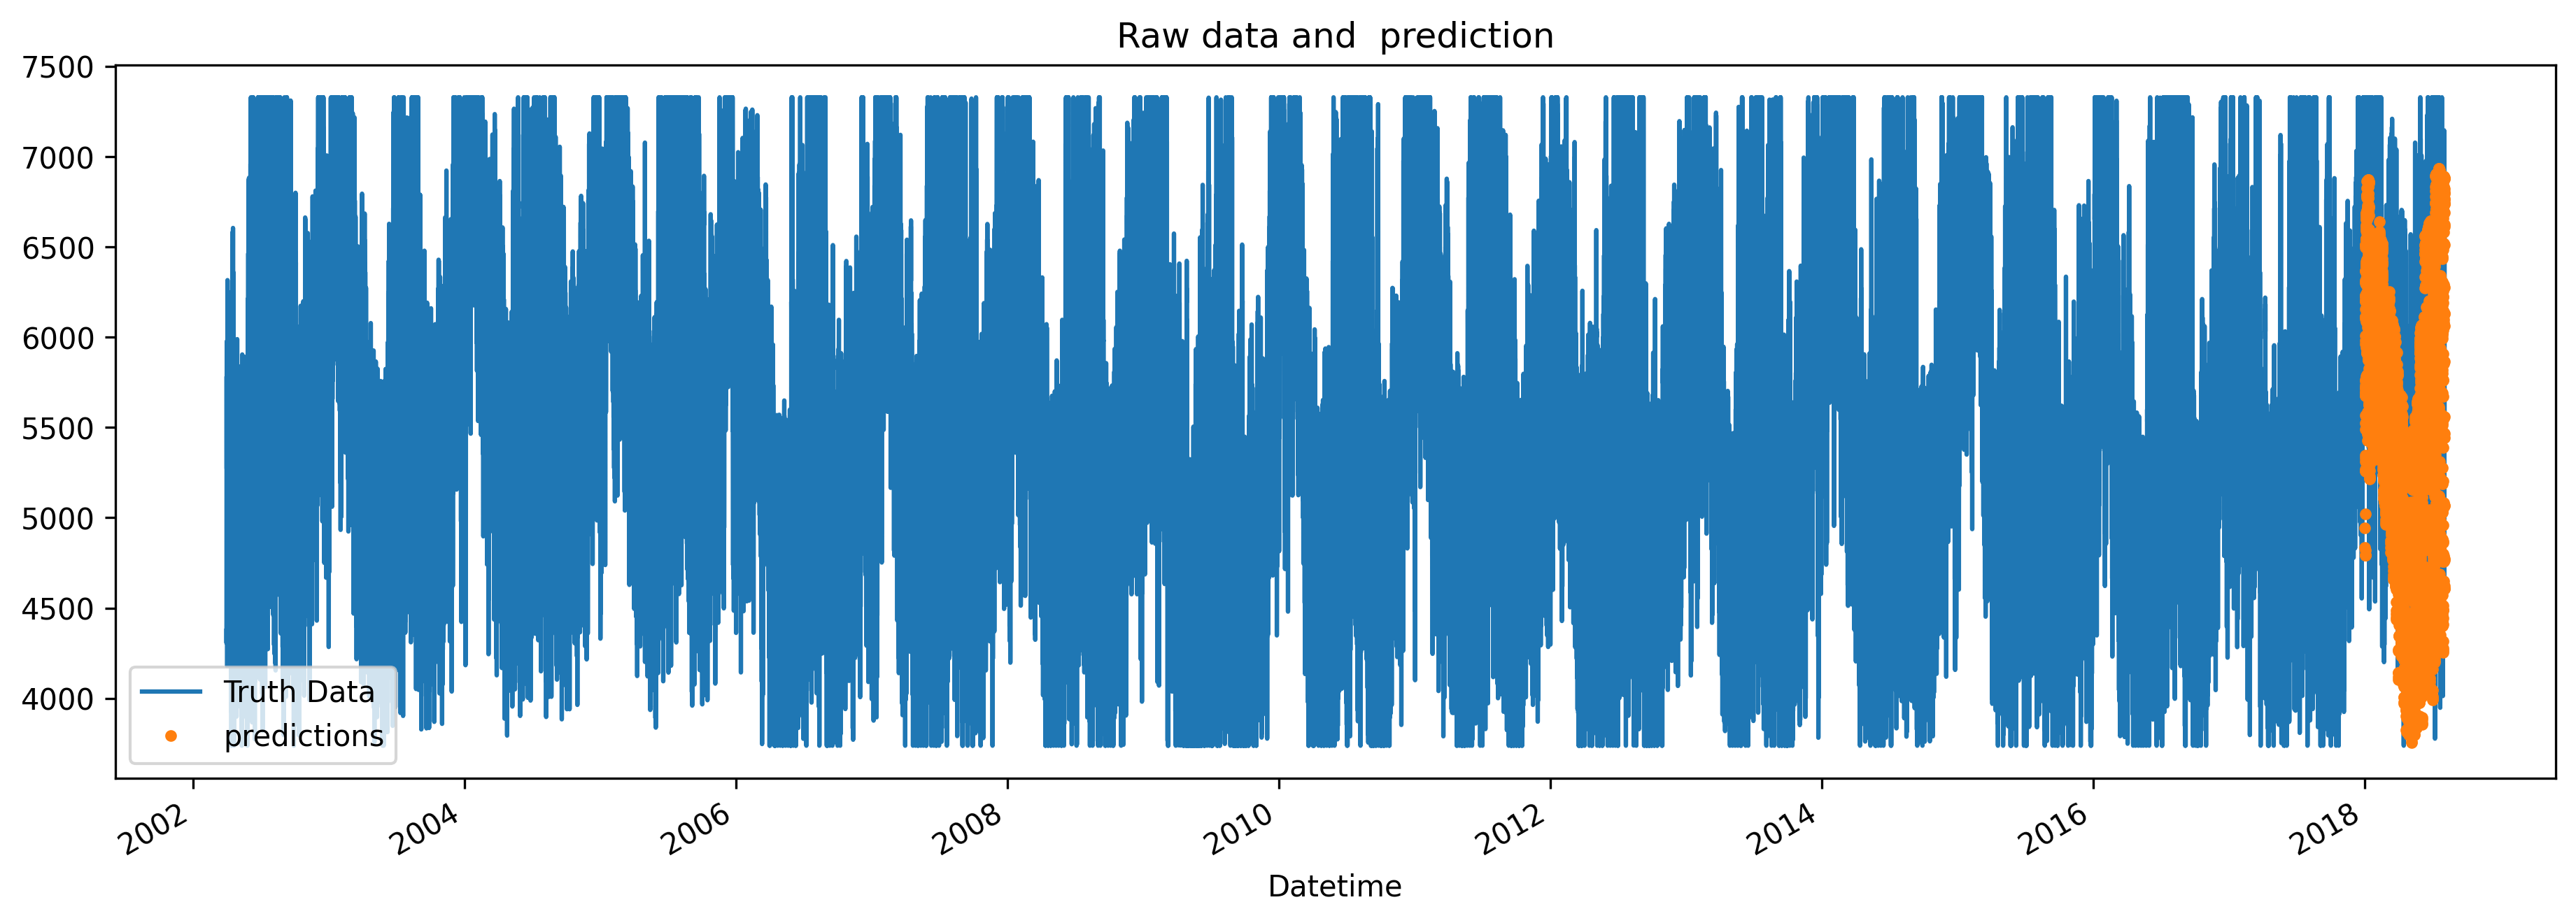

In [44]:
test['Prediction'] = xg_model.predict(xtest)
df = df.merge(test['Prediction'], how='left', left_index=True, right_index=True)
ax = df[['PJMW_MW']].plot(figsize=(15,5))
df['Prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'predictions'])
ax.set_title('Raw data and  prediction')
plt.show()

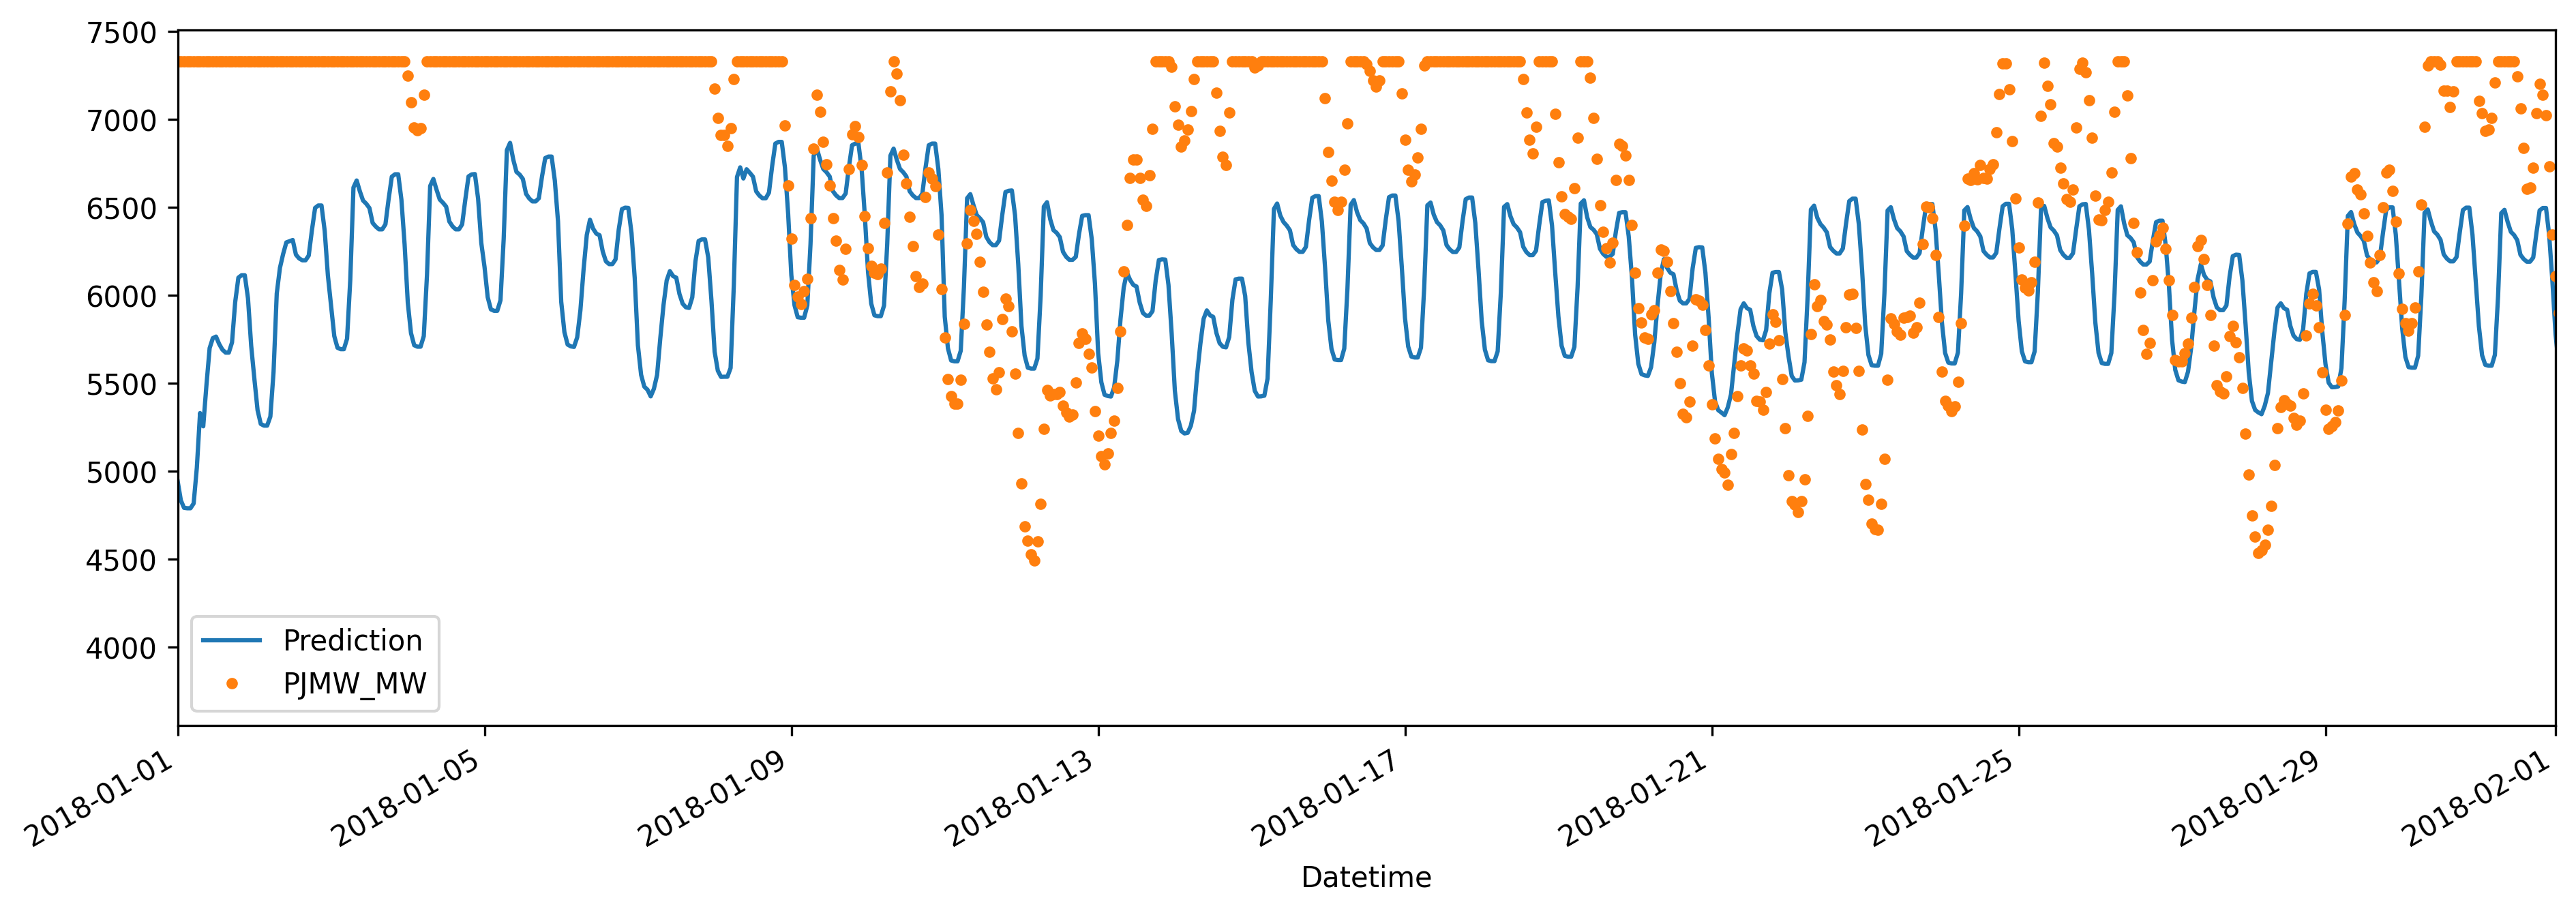

In [45]:
#First month of 2018

_, ax = plt.subplots(1)
df[['Prediction','PJMW_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower=pd.Timestamp('01-01-2018'), upper=pd.Timestamp('02-01-2018'))

In [46]:
from datetime import datetime
datetime_str = '08/03/18 00:00:00'
datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')
print(datetime_object)

2018-08-03 00:00:00


In [47]:
index_of_forecast = pd.date_range(datetime_object + pd.DateOffset(days=1), periods = 30*24, freq='H')
index_of_forecast

DatetimeIndex(['2018-08-04 00:00:00', '2018-08-04 01:00:00',
               '2018-08-04 02:00:00', '2018-08-04 03:00:00',
               '2018-08-04 04:00:00', '2018-08-04 05:00:00',
               '2018-08-04 06:00:00', '2018-08-04 07:00:00',
               '2018-08-04 08:00:00', '2018-08-04 09:00:00',
               ...
               '2018-09-02 14:00:00', '2018-09-02 15:00:00',
               '2018-09-02 16:00:00', '2018-09-02 17:00:00',
               '2018-09-02 18:00:00', '2018-09-02 19:00:00',
               '2018-09-02 20:00:00', '2018-09-02 21:00:00',
               '2018-09-02 22:00:00', '2018-09-02 23:00:00'],
              dtype='datetime64[ns]', length=720, freq='H')

In [48]:
forecast_data = pd.DataFrame(index=index_of_forecast)
forecast_data['hour'] = forecast_data.index.hour
forecast_data['dayofweek'] = forecast_data.index.dayofweek
forecast_data['quarter'] = forecast_data.index.quarter
forecast_data['month'] =forecast_data.index.month
forecast_data['year'] = forecast_data.index.year
forecast_data['dayofyear'] = forecast_data.index.dayofyear
forecast_data['dayofmonth'] = forecast_data.index.day
forecast_data['weekofyear']=forecast_data.index.weekofyear
forecast_data

hour  dayofweek  quarter  month  year  dayofyear  \
2018-08-04 00:00:00     0          5        3      8  2018        216   
2018-08-04 01:00:00     1          5        3      8  2018        216   
2018-08-04 02:00:00     2          5        3      8  2018        216   
2018-08-04 03:00:00     3          5        3      8  2018        216   
2018-08-04 04:00:00     4          5        3      8  2018        216   
...                   ...        ...      ...    ...   ...        ...   
2018-09-02 19:00:00    19          6        3      9  2018        245   
2018-09-02 20:00:00    20          6        3      9  2018        245   
2018-09-02 21:00:00    21          6        3      9  2018        245   
2018-09-02 22:00:00    22          6        3      9  2018        245   
2018-09-02 23:00:00    23          6        3      9  2018        245   

                     dayofmonth  weekofyear  
2018-08-04 00:00:00           4          31  
2018-08-04 01:00:00           4          31  
2018-08-04 02:00:00           4          31  
2018-08-04 03:00:00           4          31  
2018-08-04 04:00:00           4          31  
...                         ...         ...  
2018-09-02 19:00:00           2          35  
2018-09-02 20:00:00           2          35  
2018-09-02 21:00:00           2          35  
2018-09-02 22:00:00           2          35  
2018-09-02 23:00:00           2          35  

[720 rows x 8 columns]

In [49]:
forecast = xg_model.predict(forecast_data)
forecast = pd.DataFrame(forecast, columns=['Forecast'], index=forecast_data.index)
forecast

Forecast
2018-08-04 00:00:00  5254.828613
2018-08-04 01:00:00  4858.351562
2018-08-04 02:00:00  4550.715332
2018-08-04 03:00:00  4401.971680
2018-08-04 04:00:00  4379.068359
...                          ...
2018-09-02 19:00:00  5667.372559
2018-09-02 20:00:00  5643.396973
2018-09-02 21:00:00  5619.250488
2018-09-02 22:00:00  5450.544434
2018-09-02 23:00:00  5089.797363

[720 rows x 1 columns]

<AxesSubplot: >

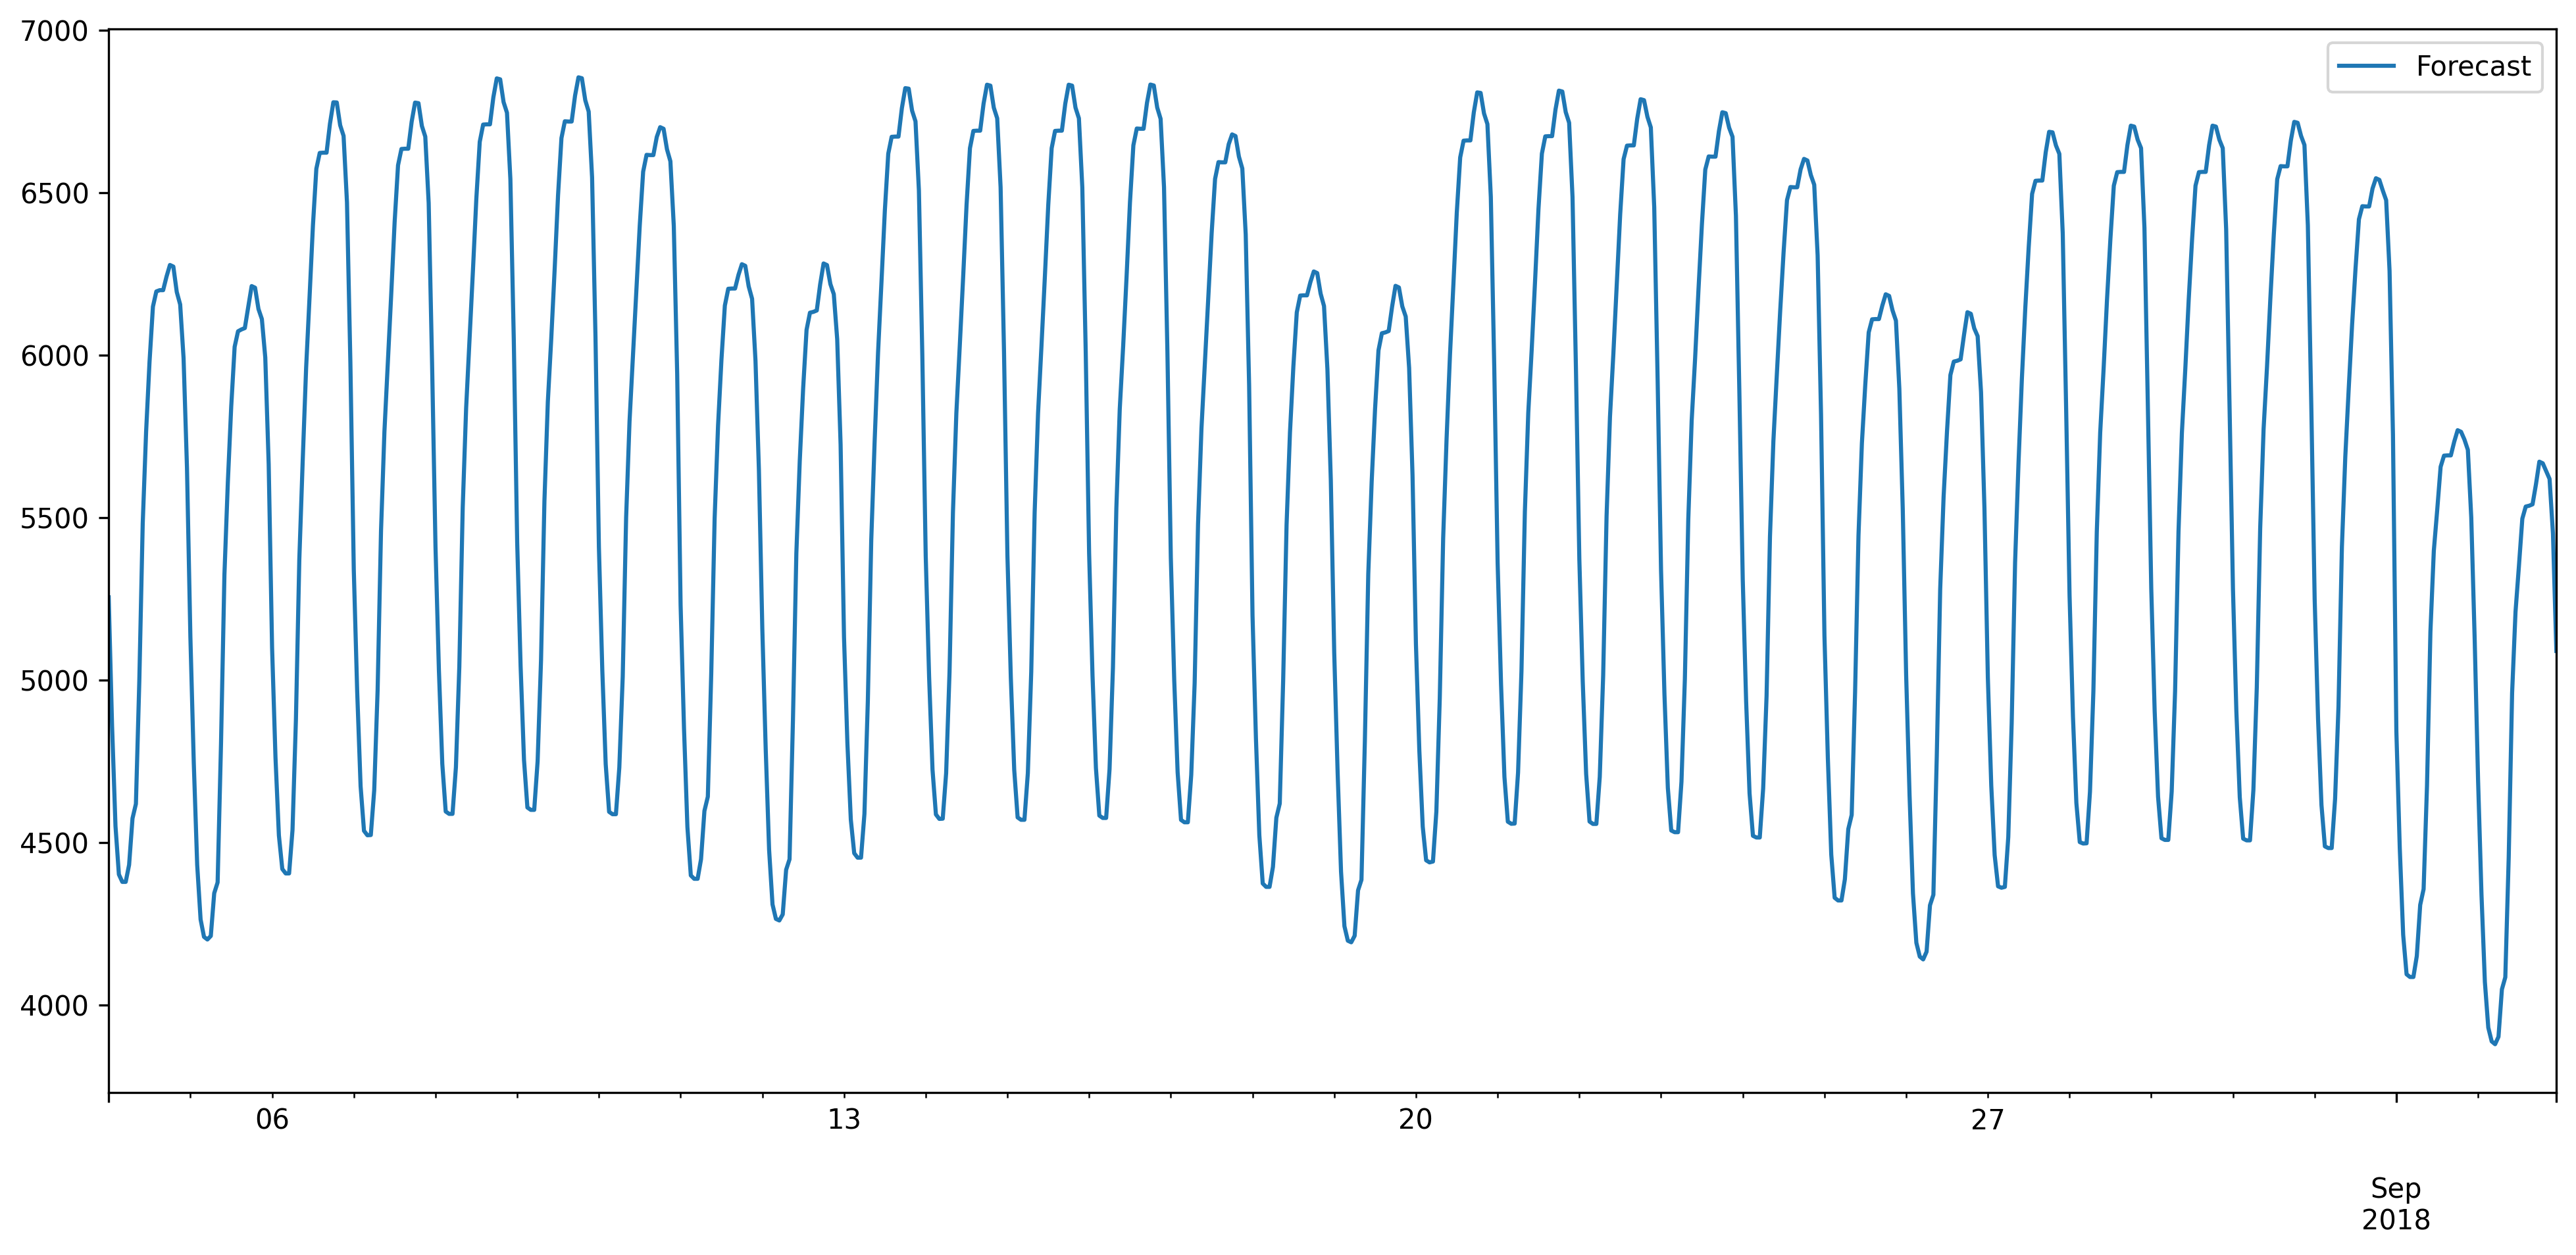

In [50]:
plt.rcParams['figure.figsize']=(16,7)
plt.rcParams['figure.dpi']=300
forecast.plot()

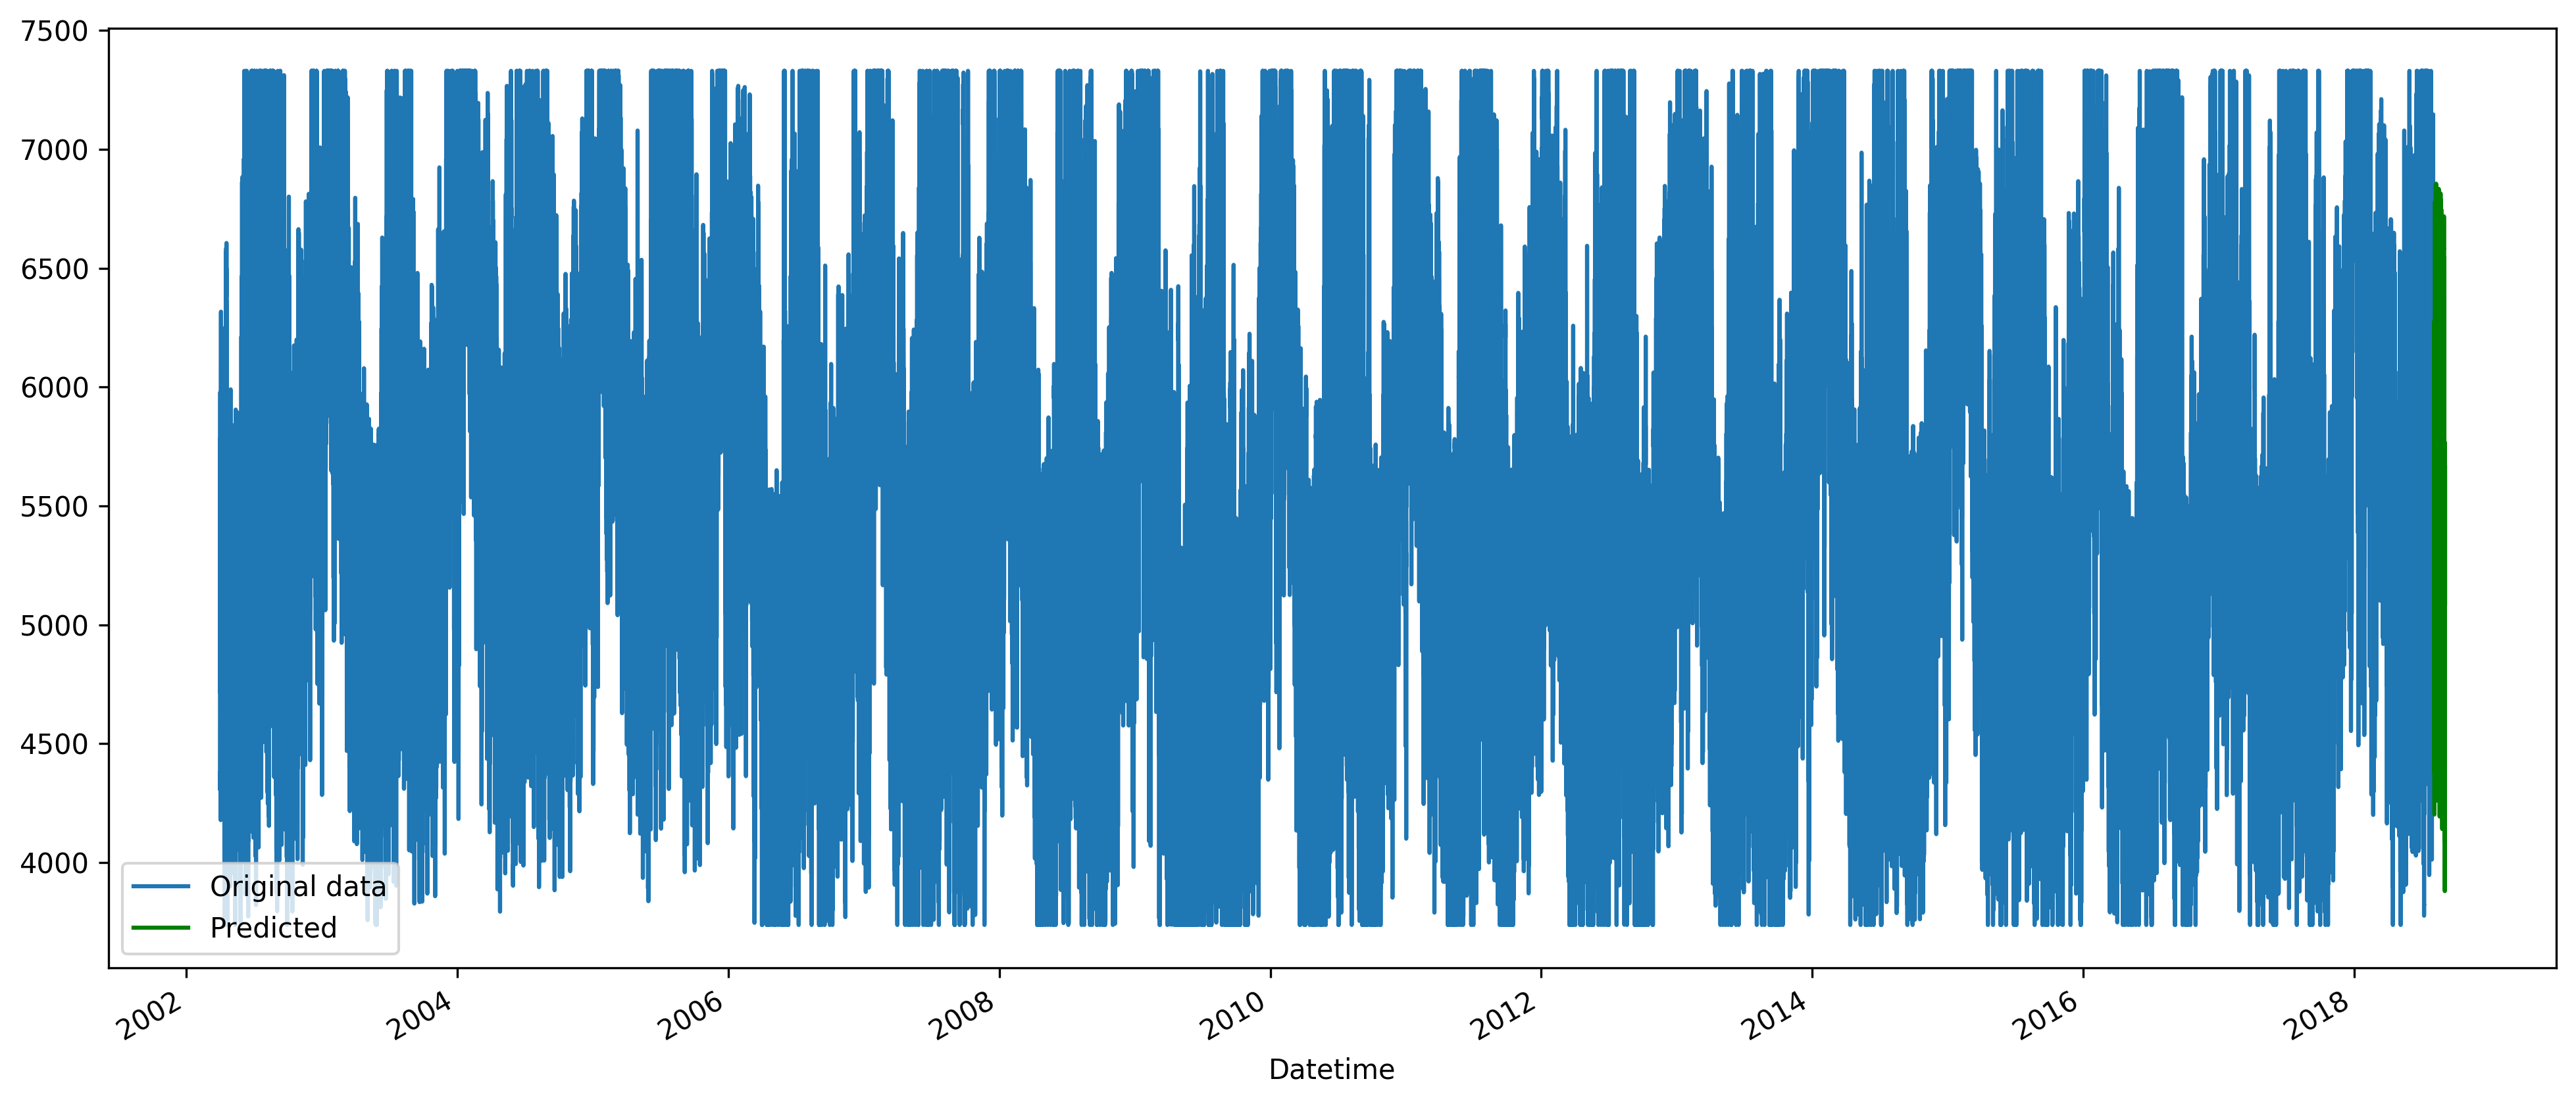

In [51]:
#All data with forecast

fig, ax = plt.subplots()
df['PJMW_MW'].plot(ax=ax, label='Original data')
forecast.plot(ax=ax, label='Forecast', color='green')
plt.legend(['Original data', 'Predicted', 'Forecast'])

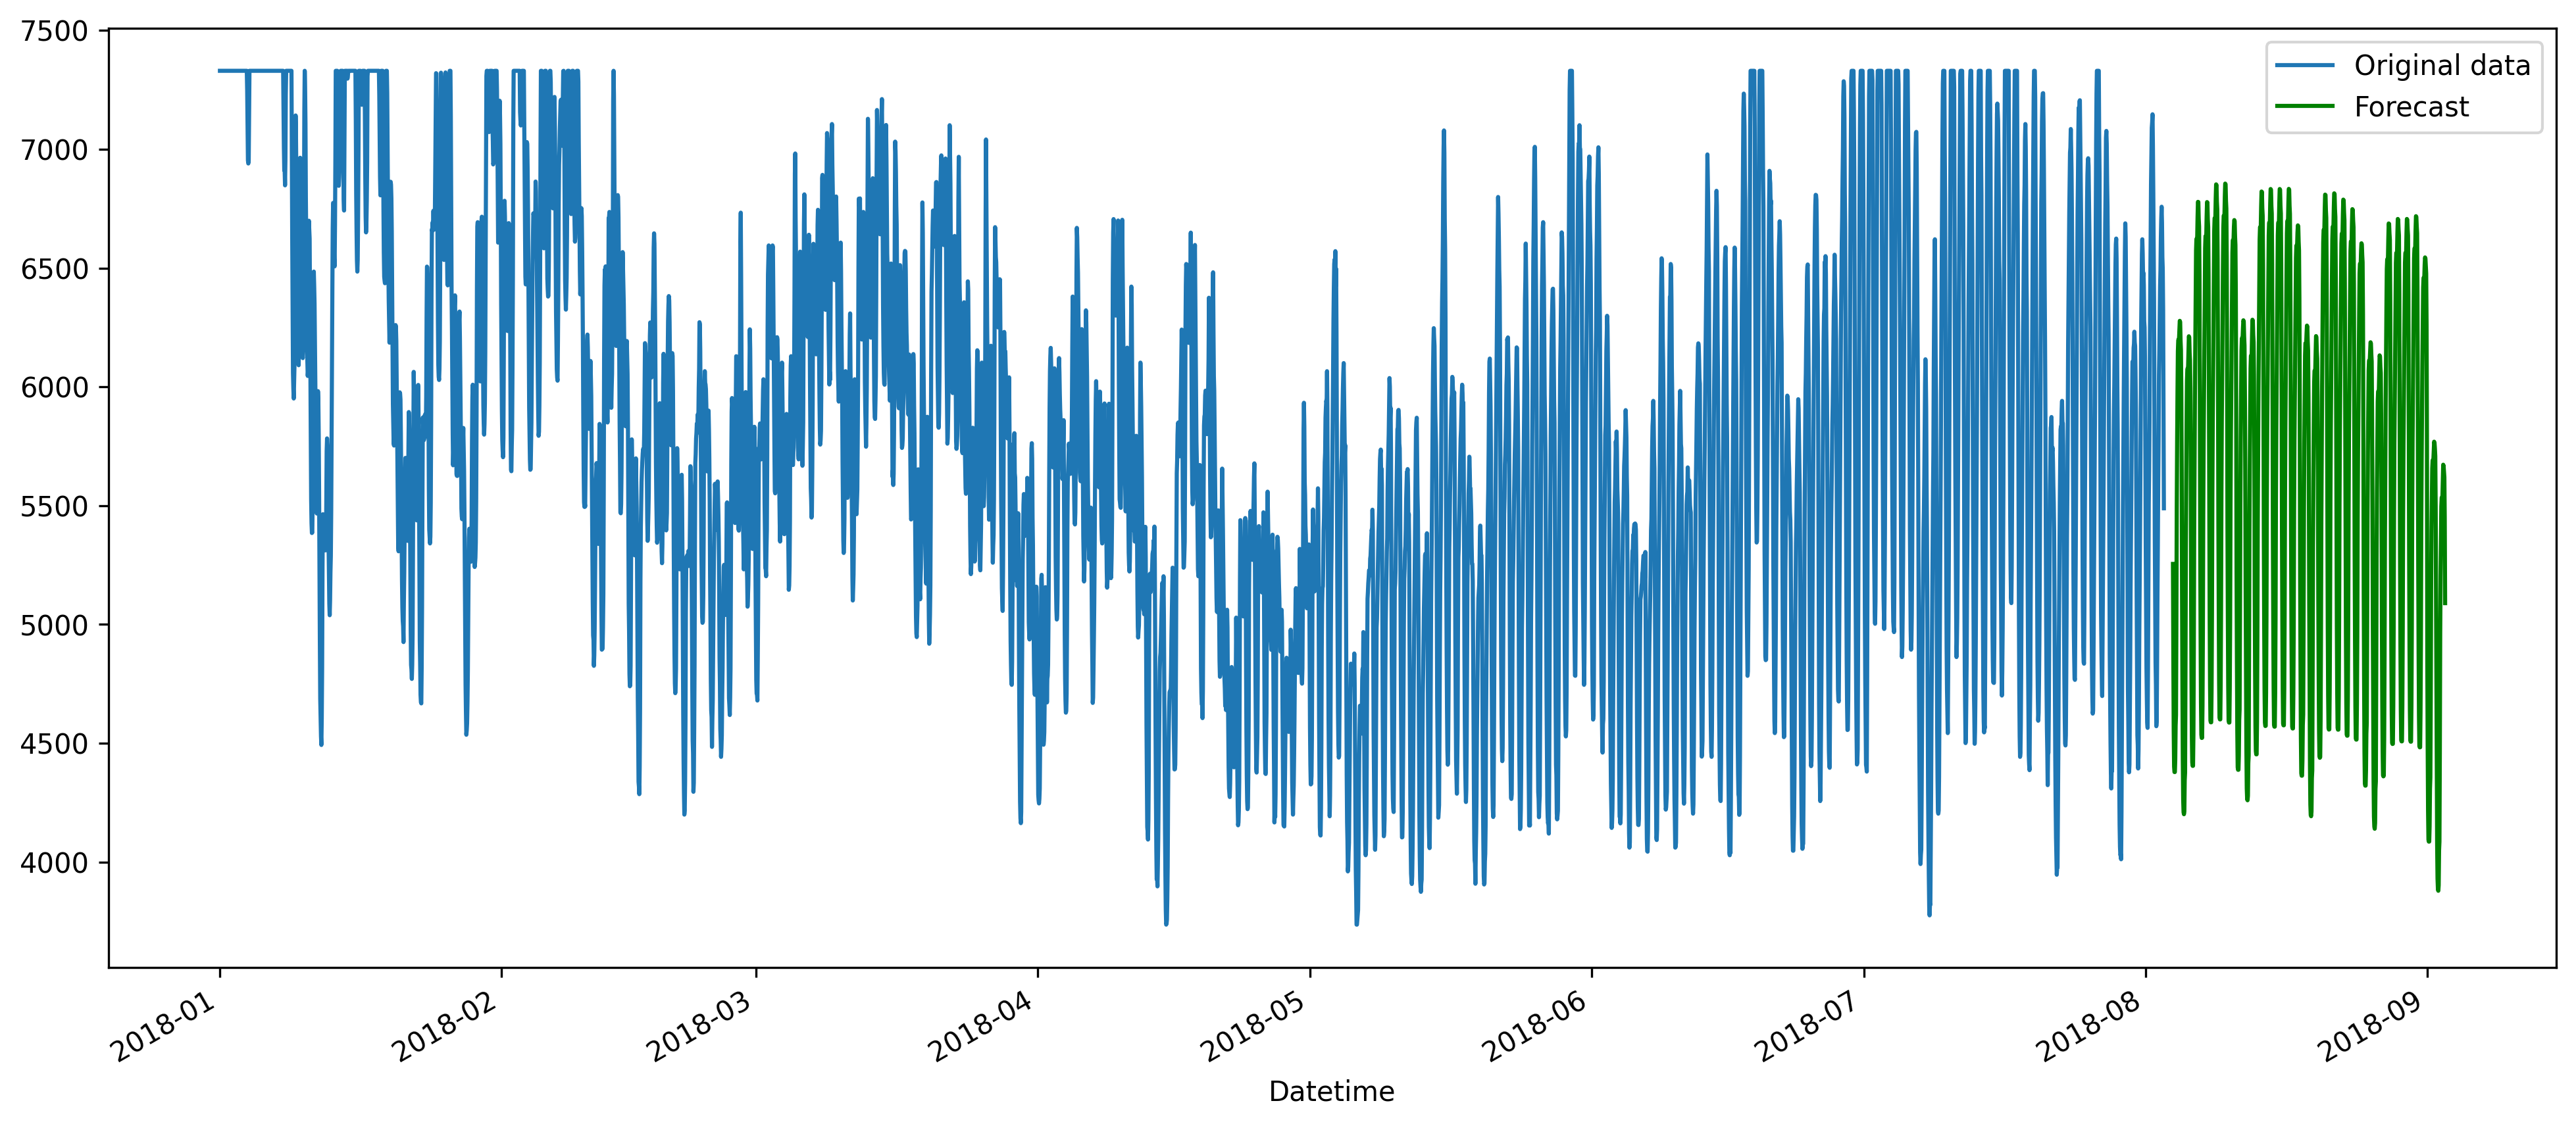

In [52]:
#Plot of test data and forecast

fig, ax = plt.subplots()
ytest['PJMW_MW'].plot(ax=ax, label='Original data')
forecast.plot(ax=ax, label='Forecast', color='green')
plt.legend(['Original data', 'Forecast'])